# Prelims

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

import textwrap

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Helpers

In [5]:
def nonzero(pred):
    ints = to_np(pred).astype(int)
    return ints[np.nonzero(ints)]

def char_label_text(pred, chunk=70):
    st = ''.join([itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

def char_split_text(pred):
    return [itos[i] for i in nonzero(pred)]

def word_label_text(pred, chunk=70):
    st = ' '.join([w_itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

## Loss and Metrics

In [7]:
def loss_prep(input, target):
    "equalize input/target sl; combine bs/sl dimensions"
    bs,tsl = target.shape
    _ ,sl,vocab = input.shape
        
    # F.pad( front,back for dimensions: 1,0,2 )
    if sl>tsl: target = F.pad(target, (0,sl-tsl))
        
    # this should only be used when testing for small seq_lens
    # if tsl>sl: target = target[:,:sl]
    
    if tsl>sl: input = F.pad(input, (0,0,0,tsl-sl))
    # not ideal => adds 82 logits all 0s...
        
    targ = target.contiguous().view(-1).long()
    pred = input.contiguous().view(-1, vocab)
    return pred, targ

In [8]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        pred,targ = loss_prep(pred, target)
        pred = F.log_softmax(pred, dim=-1)  # need this for KLDivLoss
        true_dist = pred.data.clone()
        true_dist.fill_(self.smoothing / pred.size(1))                  # fill with 0.0012
        true_dist.scatter_(1, targ.data.unsqueeze(1), self.confidence)  # [0.0012, 0.0012, 0.90, 0.0012]
        return F.kl_div(pred, true_dist, reduction='sum')/bs

In [9]:
def XE_loss(input, target):    # takes logits
    pred,targ = loss_prep(input, target)
    return F.cross_entropy(pred, targ, reduction='sum')/bs

In [10]:
def perplexity(input, target):
    pred,targ = loss_prep(input, target)
    return torch.exp(F.cross_entropy(pred, targ))

In [11]:
def acc(input, target):
    pred,targ = loss_prep(input, target)
    preds = torch.argmax(pred, dim=-1)
    return (preds==targ).float().mean()

In [12]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def _cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def _wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein package only accepts strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [13]:
def cer(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = char_label_text(res[i])
        t = char_label_text(targs[i])
        error += _cer(t,p)
    return error/bs

def wer(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_label_text(res[i])
        t = word_label_text(targs[i])
        error += _wer(t,p)
    return error/bs

## Stepper

In [14]:
def subsequent_mask(size):
    attn_shape = torch.ones((size,size), dtype=torch.int, device=device)
    mask = torch.tril(attn_shape).unsqueeze(0)
    return mask

def make_tgt_mask(tgt, pad=0):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

In [15]:
def rshift(tgt, token=1):
    "Shift y to the right by prepending token"
    return torch.cat((torch.ones((tgt.size(0),token), device=device), tgt[:,:-1]), dim=-1)

In [16]:
class TfmrStepper(Stepper):
    def step(self, xs, y, epoch):
#         self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
    
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        output = self.m(*xs, shifted_y, tgt_mask)
        
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()        
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.item()
    
    def evaluate(self, xs, y):
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        preds = self.m(*xs, shifted_y, tgt_mask)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)

# Data

## 3x1

In [57]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
FOLDER = 'synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [58]:
sz,bs = 128,100  #256,60  #128,100
seq_len = 45
stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))  # inception_stats

## 3x2

In [78]:
fname = 'multi_synth_words_50000.csv' if device.type == 'cuda' else 'multi_synth_words.csv'
CSV = PATH/fname
FOLDER = 'multi_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [79]:
sz,bs = 400,45   #256,60
seq_len = 75
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## Mix

### Create CSV

In [37]:
single_filename = ['single_'+f for f in csv.filename.values]
single_char_ids = csv.char_ids.values

In [39]:
multi_filename = ['multi_'+f for f in csv.filename.values]
multi_char_ids = csv.char_ids.values

In [ ]:
# large_filename = ['large_'+f for f in csv.filename.values]
# large_char_ids = csv.char_ids.values

In [48]:
mix_filename = single_filename + multi_filename # + large_filename
mix_char_ids = np.concatenate((single_char_ids, multi_char_ids)) #, large_char_ids))

In [49]:
d = {'filename': mix_filename, 'char_ids': mix_char_ids}

In [50]:
df = pd.DataFrame.from_dict(d)
df.sample(5)

filename                                           char_ids
62383   multi_12383.png  74 76 71 71 67 64 60 59 1 78 63 64 67 60 1 58 ...
95345   multi_45345.png  60 77 60 73 80 70 69 60 1 74 70 68 60 1 71 70 ...
41979  single_41979.png  59 70 78 69 1 69 60 60 59 60 59 1 74 80 74 75 ...
62385   multi_12385.png  57 60 67 64 60 77 60 59 1 58 70 68 68 56 69 59...
27363  single_27363.png  78 63 70 74 60 1 66 69 70 78 1 75 73 70 70 71 ...

In [51]:
samp = df.sample(50000)
samp.head()

filename                                           char_ids
41527  single_41527.png    34 59 60 69 1 58 67 70 74 60 1 56 57 70 76 75 3
73031   multi_23031.png  78 63 60 69 1 37 70 76 74 64 69 62 1 75 56 67 ...
34619  single_34619.png       73 60 74 75 1 75 70 78 69 1 47 70 67 67 80 3
40530  single_40530.png  57 73 70 66 60 69 1 74 76 71 71 67 64 60 59 1 ...
19294  single_19294.png    67 60 56 59 1 64 75 74 60 67 61 1 75 63 56 69 3

In [52]:
samp.to_csv(PATH/'sample_mix_synth_words.csv', columns=['filename', 'char_ids'], index=False)

In [53]:
df.to_csv(PATH/'mix_synth_words.csv', columns=['filename', 'char_ids'], index=False)

In [54]:
lengths = np.array([len(i.split(' ')) for i in csv.char_ids.values])
lengths.max()

51

### Fix Bad Data

In [131]:
row = csv[csv['char_ids'].str.startswith('32 70 69 74 75 64 75 76 75 64 70 69 1 75 70 78 56 73 59 1 71')]
row

filename                                           char_ids
44247  multi_38475.png  32 70 69 74 75 64 75 76 75 64 70 69 1 75 70 78...

In [134]:
c_ids = csv.loc[row.index.item()].char_ids
c_ids

'32 70 69 74 75 64 75 76 75 64 70 69 1 75 70 78 56 73 59 1 71 56 74 74 60 69 62 60 73 74 1 66 69 70 78 1 68 70 76 67 59 74 1 59 60 77 60 67 70 71 68 60 69 75 3'

In [ ]:
stoi = {v:k for k,v in enumerate(itos)}

In [ ]:
string = ''.join([itos[int(i)] for i in c_ids.split(' ')])
string

In [ ]:
string.index('aluminium')

In [ ]:
string = string.replace('aluminium', 'of the', 1)
string

In [ ]:
ids = np.array([stoi[letter] for letter in string[:-5]] + [3])
ids

In [ ]:
str_ids = ' '.join([str(l) for l in ids])
str_ids

In [ ]:
samp.loc[103388].char_ids = str_ids
df.loc[103388].char_ids = str_ids

### Load

In [17]:
# fname = 'mix_synth_words.csv'         #100000
fname = 'sample_mix_synth_words.csv'   #50000

CSV = PATH/fname
FOLDER = 'mix_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [18]:
sz,bs = 256,60  #128,100
seq_len = 75
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## Large

In [17]:
CSV = PATH/'large_synth_words_50000.csv'
FOLDER = 'large_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [18]:
sz,bs = 512,30  #256,60  #512,30  #400,45
seq_len = 250
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## Concat Lines

In [34]:
nums = 'pg'   #'9-12'  #'678'  #'345'  #pg 
CSV = PATH/f'cat_lines_{nums}.csv'
FOLDER = 'resized_cat_lines'

csv = pd.read_csv(CSV)
test = pd.read_csv(PATH/'test_pg.csv')

len(csv), len(test)

(11308, 231)

In [66]:
lengths = np.array([len(i.split(' ')) for i in csv.char_ids.values])
lengths.max()

632

In [35]:
sz,bs = 1000,5  #800,10   #512,20
seq_len = 600 #600 #450  #300
stats = (np.array([0.94161, 0.94161, 0.94161]), np.array([0.12835, 0.12835, 0.12835]))

### Concat All

In [ ]:
a = pd.read_csv(PATH/'cat_lines_3.csv').sample(1000)
b = pd.read_csv(PATH/'cat_lines_4.csv').sample(1000)
c = pd.read_csv(PATH/'cat_lines_5.csv').sample(1000)
d = pd.read_csv(PATH/'cat_lines_6.csv').sample(1000)
e = pd.read_csv(PATH/'cat_lines_7.csv').sample(1000)
f = pd.read_csv(PATH/'cat_lines_8.csv').sample(1000)
g = pd.read_csv(PATH/'cat_lines_9.csv').sample(1000)
h = pd.read_csv(PATH/'cat_lines_10.csv').sample(1000)
i = pd.read_csv(PATH/'cat_lines_11.csv').sample(1000)
j = pd.read_csv(PATH/'cat_lines_12.csv').sample(1000)

In [38]:
k = pd.read_csv(PATH/'paragraph_chars.csv')

In [43]:
val_idxs = np.array(k.sample(frac=0.15, random_state=42).index)

In [62]:
trn = k[~k.index.isin(val_idxs)]
test = k[k.index.isin(val_idxs)]

In [63]:
new = pd.concat([a,b,c,d,e,f,g,h,i,j,trn], ignore_index=True)
len(new)

11308

In [64]:
# new.to_csv(PATH/'cat_lines_pg.csv', index=False)
# test.to_csv(PATH/'test_pg.csv', index=False)

## Paragraphs

In [34]:
CSV = PATH/'paragraph_chars.csv'
FOLDER = 'paragraphs'

csv = pd.read_csv(CSV)
len(csv)

1539

In [35]:
sz,bs = 1000,5  #1024,5  #   #~2000x1000 full size
seq_len = 700   #~400 chars/paragraph - max: 705
stats = (np.array([0.94161, 0.94161, 0.94161]), np.array([0.12835, 0.12835, 0.12835]))

## Words

In [32]:
w_itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

In [41]:
name = CSV.stem[:-1] + '_ids' + CSV.suffix    # 'synth_words.csv' => 'synth_word_ids.csv'
W_CSV = PATH/name

# W_CSV = PATH/'multi_synth_word_ids.csv'
# FOLDER = 'multi_synth_words'

In [42]:
w_csv = pd.read_csv(W_CSV)
len(w_csv)

10000

## ModelData

In [59]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

val_idxs = np.array(csv.sample(frac=0.15, random_state=42).index)

f = resnet34

In [60]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]
# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [61]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Verify Data

In [157]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.trn_dl))
# imgs = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


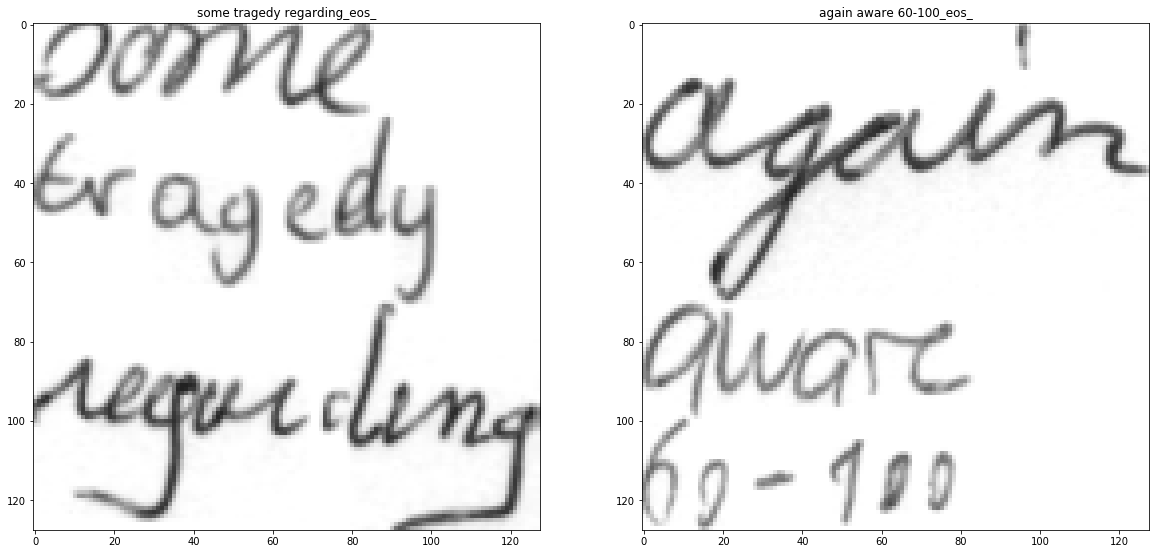

In [158]:
fig, axes = plt.subplots(1,2, gridspec_kw={'hspace': 0.3}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    t = char_label_text(y[i])
    ax=show_img(denorm(x[i])[0], ax=ax, title=t)

## Combine word/char datasets

In [14]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [15]:
w_data = ImageClassifierData.from_csv(PATH, FOLDER, W_CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)
w_data.aug_dl.pre_pad=False
w_data.trn_dl.pre_pad=False
w_data.val_dl.pre_pad=False

NameError: name 'W_CSV' is not defined

In [ ]:
trn_ds = ConcatLblDataset(data.trn_ds, w_data.trn_y)
val_ds = ConcatLblDataset(data.val_ds, w_data.val_y)
data.trn_dl.dataset = trn_ds
data.val_dl.dataset = val_ds

### Verify multi dataset

In [ ]:
denorm = data.trn_ds.ds.denorm   # need the extra .ds when using ConcatLblDataset
_,(y0,y1) = next(iter(data.trn_dl))

In [ ]:
chars = [itos[int(w)] for w in y0[-2]]
''.join(chars)

In [ ]:
words = [w_itos[int(c)] for c in y1[-2]]
' '.join(words)

# Transformer Modules

In [22]:
# similar to batchnorm but on a layer level
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [23]:
class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [24]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [25]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [26]:
class EncoderLayer(nn.Module):
    "Encoder: self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

In [27]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, src, tgt_mask)
        return self.norm(x)

In [28]:
class DecoderLayer(nn.Module):
    "Decoder: self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # wraps layer in residual,dropout,norm
 
    def forward(self, x, src, tgt_mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, src, src))
        return self.sublayer[2](x, self.feed_forward)

In [29]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)  #(bs, sl, hw)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)    
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn   #(bs, sl, d_model)

In [30]:
class SingleHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(SingleHeadedAttention, self).__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):        
        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        return self.linears[-1](x)

In [31]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, h=1, dropout=0.2):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h        # assume d_v always equals d_k
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        if mask is not None: mask = mask.unsqueeze(1)
        bs = q.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        q, k, v = [l(x).view(bs, -1, self.h, self.d_k).transpose(1,2) for l, x in zip(self.linears, (q, k, v))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(q, k, v, mask=mask, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [32]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*4)
        self.w_2 = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [33]:
class PositionalEncoding(nn.Module):
    "Modified the PE function for 2 dimensions"
    def __init__(self, d_model, dims=1, dropout=0.1, max_len=2000):
        super(PositionalEncoding, self).__init__()
        assert dims<=2, "More than 2 dimensional PE is not implemented"
        
        self.dropout = nn.Dropout(p=dropout)
        self.dims = dims
        
        channels = d_model//dims
        pe = torch.zeros(max_len, channels)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        log_increment = math.log(1e4) / channels
        div_term = torch.exp(torch.arange(0.0, channels, 2) * -log_increment)  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.unsqueeze_(0)
        
        if dims==2:
            w_pe = F.pad(pe, (0,channels)).unsqueeze(2)
            h_pe = F.pad(pe, (channels,0)).unsqueeze(1)
            pe = w_pe + h_pe

        self.register_buffer('pe', pe)    #(1,max_len,max_len,d_model)
        
    def forward(self, x):
        # 1d: ([bs, sl, d_model])     2d: ([bs, h, w, d_model])
        if self.dims == 1:
            x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        else:
            x = x + Variable(self.pe[:, :x.size(1), :x.size(2)], requires_grad=False)
        return self.dropout(x)

In [94]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.base(x)

# Full Arch

In [84]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(src)
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

In [85]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz, d_model):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        self.linear = nn.Linear(em_sz, d_model)
        
    def forward(self, x):
        x = self.base(x).flatten(2,3).permute(0,2,1)
        x = self.linear(x) * math.sqrt(self.linear.out_features)
        return x

In [86]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [87]:
def make_full_model(vocab, d_model=512, N=4, drops={'attn':0.2, 'ff':0.2, 'pos':0.2, 'layer':0.2}):
    c = copy.deepcopy
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drops['ff'])

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops['layer']), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drops['layer']), N),
        nn.Sequential(
            Embeddings(d_model, vocab), PositionalEncoding(d_model, 1, drops['pos'], 5000)
        ),
        nn.Linear(d_model, vocab)
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [88]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)                            # ([bs, h*w, d_model])
        dec_outs = self.transformer(feats, tgt, tgt_mask)    # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out

    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.transformer.encode(self.img_enc(src))
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer.decode(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [89]:
d_model = 512
em_sz = 256
img_encoder = ResnetBase(em_sz, d_model)
transformer = make_full_model(len(itos), d_model)
net = Img2Seq(img_encoder, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, BasicModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [cer]

# Experimental Full Arch

In [95]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(self.src_embed(src))
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

In [96]:
# class Embeddings(nn.Module):
#     def __init__(self, d_model, vocab):
#         super(Embeddings, self).__init__()
#         self.lut = nn.Embedding(vocab, d_model)
#         self.d_model = d_model

#     def forward(self, x):
#         return self.lut(x) * math.sqrt(self.d_model)

In [105]:
class ImageAdaptor(nn.Module):
    def __init__(self, em_sz, d_model, drop=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.linear = nn.Linear(em_sz, d_model)
        self.adaptor = nn.Sequential( nn.Conv2d(em_sz, d_model, 1), nn.BatchNorm2d(d_model) )
        self.dropout = nn.Dropout(drop)
        
    def forward(self, x):
#         x = x.flatten(2,3).permute(0,2,1)
#         x = self.linear(x) * math.sqrt(self.d_model)
        x = self.adaptor(x)
        x = self.dropout(x.flatten(2,3).permute(0,2,1))
        return x

In [98]:
def make_full_model(vocab, em_sz=256, d_model=512, N=4, drop=0.2):
    c = copy.deepcopy
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drop)

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drop), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drop), N),
        ImageAdaptor(em_sz, d_model),
        nn.Sequential(
            nn.Embedding(vocab, d_model), PositionalEncoding(d_model, 1, drop, 5000)
        ),
        nn.Linear(d_model, vocab)
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [99]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)                            # ([bs, h*w, d_model])
        dec_outs = self.transformer(feats, tgt, tgt_mask)    # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out

    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.transformer.encode(self.img_enc(src))
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer.decode(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [106]:
d_model = 512
em_sz = 256
img_encoder = ResnetBase(em_sz)
transformer = make_full_model(len(itos), em_sz, d_model)
net = Img2Seq(img_encoder, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, BasicModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [cer, acc]

# Prob Distribution Arch

In [47]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(self.src_embed(src))
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

In [48]:
class ImageAdaptor(nn.Module):
    def __init__(self, em_sz, d_model, drop=0.1):
        super().__init__()
        
        self.adaptor = nn.Sequential(
            nn.Conv2d(em_sz, d_model, 1),
            nn.BatchNorm2d(d_model)
        )
#         self.pos_enc = PositionalEncoding(d_model, dims=2)
        self.dropout = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.adaptor(x).permute(0,2,3,1)         # bs,h,w,d_model
#         x = self.pos_enc(x)
        x = x.flatten(1,2).contiguous()
        x = self.dropout(x)
        return x

In [49]:
class SmoothDist(nn.Module):
    def __init__(self, vocab, d_model, smoothing=0.3):
        super().__init__()
        
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.vocab = vocab
        
        self.linear = nn.Linear(vocab, d_model)
        
    def forward(self, x):
        bs,sl = x.shape
        dist = torch.zeros((bs,sl,self.vocab), device=device)
        dist.fill_(self.smoothing / (self.vocab-1))
        smooth = dist.scatter_(2, x.unsqueeze(2), self.confidence)
        return self.linear(smooth)

In [50]:
def make_full_model(vocab, em_sz=256, d_model=512, N=4, drop=0.2):
    c = copy.deepcopy
#     attn = MultiHeadedAttention(d_model, 4)
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drop)

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drop), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drop), N),
        ImageAdaptor(em_sz, d_model, drop=0.1),
        nn.Sequential(
            SmoothDist(vocab, d_model, 0.3),
#             nn.Embedding(vocab, d_model),
            PositionalEncoding(d_model, dims=1),
            nn.Dropout(0.1)
        ),
        nn.Sequential(
            nn.Linear(d_model, vocab),
        )
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
        
    model.tgt_embed[0].linear.weight.data = model.generator[0].weight.t()
    
    return model

In [51]:
class Img2Seq(nn.Module):
    def __init__(self, img_enc, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_enc
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)
        dec_outs = self.transformer(feats, tgt, tgt_mask)      # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out

    
    # paper: beam search with a beam size of 4 and length penalty α = 0.6
    
    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.transformer.encode(self.img_enc(src))
            bs = src.size(0)
            tgt = smooth_one_hot(torch.ones((bs,1), dtype=torch.long, device=device))

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer.decode(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                
                new = F.log_softmax(prob, dim=-1)
                if (torch.argmax(new, dim=-1)==0).all(): break
                    
                tgt = torch.cat([tgt,new.unsqueeze(1)], dim=1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [52]:
em_sz = 256
d_model = 512
transformer = make_full_model(len(itos), em_sz, d_model)
img_enc = ResnetBase(em_sz)
net = Img2Seq(img_enc, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, BasicModel(to_gpu(net)), opt_fn=opt_fn)
# learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [cer, acc]

# Positional Arch

In [36]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(self.src_embed(src))
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

In [38]:
class ImageAdaptor(nn.Module):
    def __init__(self, em_sz, d_model, drop=0.1):
        super().__init__()
        
        self.adaptor = nn.Sequential(
            nn.Conv2d(em_sz, d_model, 1),
            nn.BatchNorm2d(d_model)
        )
        self.pos_enc = PositionalEncoding(d_model, dims=2)
        self.dropout = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.adaptor(x).permute(0,2,3,1)         # bs,h,w,d_model
        x = self.pos_enc(x)
        x = x.flatten(1,2).contiguous()
        x = self.dropout(x)
        return x

In [39]:
class PosEncInputs(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        
        self.d_model = d_model
        
    def forward(self, tgt):
        bs,sl = tgt.shape
        return torch.zeros((bs,sl,self.d_model), device=device)

In [40]:
def make_full_model(vocab, em_sz=256, d_model=512, N=4, drop=0.2):
    c = copy.deepcopy
#     attn = MultiHeadedAttention(d_model, 4)
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drop)

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drop), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drop), N),
        ImageAdaptor(em_sz, d_model, drop=0.1),
        nn.Sequential(
            PosEncInputs(d_model),
#             nn.Embedding(vocab, d_model),
            PositionalEncoding(d_model, dims=1),
            nn.Dropout(0.1)
        ),
        nn.Sequential(
            nn.Linear(d_model, vocab),
        )
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return model

In [41]:
class Img2Seq(nn.Module):
    def __init__(self, img_enc, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_enc
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):        
        feats = self.img_enc(src)
        dec_outs = self.transformer(feats, tgt, tgt_mask)      # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)              # ([bs, sl, vocab])
        return out

    
    # paper: beam search with a beam size of 4 and length penalty α = 0.6
    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.transformer.encode(self.img_enc(src))
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer.decode(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [42]:
em_sz = 256
d_model = 512
transformer = make_full_model(len(itos), em_sz, d_model)
img_enc = ResnetBase(em_sz)
net = Img2Seq(img_enc, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, BasicModel(to_gpu(net)), opt_fn=opt_fn)
# learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [cer, acc]

# LMMixer Architecture

In [21]:
# similar to batchnorm but on a layer level
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [22]:
class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [23]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [24]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src):
        for layer in self.layers:
            x = layer(x, src)
        return self.norm(x)

In [25]:
class EncoderLayer(nn.Module):
    "Encoder: src-attn and feed forward"
    def __init__(self, size, src_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x, src):
        x = self.sublayer[0](x, lambda x: self.src_attn(x, src, src))
        return self.sublayer[1](x, self.feed_forward)

In [26]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [27]:
class DecoderLayer(nn.Module):
    "Decoder: self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
 
    def forward(self, x, mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [28]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)  #(bs, sl, hw)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)    
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn   #(bs, sl, d_model)

In [29]:
class SingleHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(SingleHeadedAttention, self).__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 3) #4
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):        
        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        return x #self.linears[-1](x)

In [30]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*4)
        self.w_2 = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [31]:
class PositionalEncoding(nn.Module):
    "Modified the PE function for 2 dimensions"
    def __init__(self, d_model, dims=1, dropout=0.2, max_len=2000):
        super(PositionalEncoding, self).__init__()
        assert dims<=2, "More than 2 dimensional PE is not implemented"
        
        self.dropout = nn.Dropout(p=dropout)
        self.dims = dims
        
        channels = d_model//dims
        pe = torch.zeros(max_len, channels)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        log_increment = math.log(1e4) / channels
        div_term = torch.exp(torch.arange(0.0, channels, 2) * -log_increment)  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.unsqueeze_(0)
        
        if dims==2:
            w_pe = F.pad(pe, (0,channels)).unsqueeze(2)
            h_pe = F.pad(pe, (channels,0)).unsqueeze(1)
            pe = w_pe + h_pe

        self.register_buffer('pe', pe)    #(1,max_len,max_len,d_model)
        
    def forward(self, x):
        # 1d: ([bs, sl, d_model])     2d: ([bs, h, w, d_model])
        if self.dims == 1:
            x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        else:
            x = x + Variable(self.pe[:, :x.size(1), :x.size(2)], requires_grad=False)
            x = x.flatten(1,2).contiguous()
        return self.dropout(x)

In [32]:
class Mixer(nn.Module):
    def __init__(self, d_model, drop):
        super(Mixer, self).__init__()
        
        self.linears = clones(nn.Linear(d_model, d_model), 2)
        self.out = nn.Linear(d_model*2, d_model)
        self.drop = nn.Dropout(drop)
        self.norm = LayerNorm(d_model)
        
    def forward(self, enc, dec):
        x = torch.cat([self.linears[0](enc), self.linears[1](dec)], dim=-1)
        x = self.out(self.drop(x))
        return self.norm(x)

In [33]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, mixer, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mixer = mixer
        self.tgt_embed = tgt_embed
        self.generator = generator
        self.embed = None
        
    def forward(self, src, tgt, tgt_mask=None):
        enc = self.encode(tgt, src)
        dec = self.decode(tgt_mask)
        return self.mixer(enc,dec)
#         return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, tgt, src):
        self.embed = self.tgt_embed(tgt)
        return self.encoder(self.embed, src)
    
    def decode(self, tgt_mask=None):
        return self.decoder(self.embed, tgt_mask)        
        
    def generate(self, outs):
        return self.generator(outs)

## Arch

In [37]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz, d_model):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        
        self.adaptor = nn.Sequential(
            nn.Conv2d(em_sz, d_model, 1),
            nn.BatchNorm2d(d_model)
        )
        
    def forward(self, x):
        x = self.base(x)
        x = self.adaptor(x).permute(0,2,3,1)         # bs,h,w,d_model
        return x.flatten(1,2).contiguous()

In [38]:
def make_full_model(vocab, d_model=512, N=4, drops={'attn':0.2, 'ff':0.2, 'pos':0.2, 'layer':0.2}):
    c = copy.deepcopy
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drops['ff'])

    model = EncoderDecoder(
#         PositionalEncoding(d_model, 2, drops['pos']),
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops['layer']), N),
        Decoder(DecoderLayer(d_model, c(attn), c(ff), drops['layer']), N),
        Mixer(d_model, drops['layer']),
        nn.Sequential(
            nn.Embedding(vocab, d_model),
            PositionalEncoding(d_model, 1, drops['pos'])
        ),
        nn.Linear(d_model, vocab)
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [39]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)                            # ([bs, h*w, d_model])
        dec_outs = self.transformer(feats, tgt, tgt_mask)    # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out

    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.img_enc(src)
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [40]:
d_model = 512
em_sz = 256
img_encoder = ResnetBase(em_sz, d_model)
transformer = make_full_model(len(itos), d_model)
net = Img2Seq(img_encoder, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [char_error_rate]

# Train

### load state dict for changes

In [81]:
#LM
LM_PATH = Path('data/wikitext/wikitext-2-raw')
sd = torch.load(LM_PATH/'models'/'LM.h5', map_location=lambda storage, loc: storage)

In [ ]:
sd = torch.load(PATH/'models'/'tfmr_paragraph.h5', map_location=lambda storage, loc: storage)
sd.pop('img_enc.linear.bias')   # need to remove mismatched linear weight

In [82]:
learn.model.load_state_dict(sd, strict=False)

### load model

In [40]:
learn.load('tfmr_catpg_1000')

## LR find

 67%|██████▋   | 283/425 [01:41<00:50,  2.79it/s, loss=341]

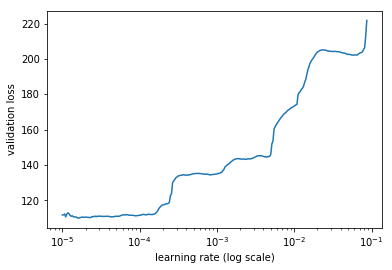

In [109]:
learn.lr_find(stepper=TfmrStepper)
learn.sched.plot(n_skip=0, n_skip_end=2)

## Experimentation

In [41]:
#gpu
lr=1e-4
learn.fit(lr, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5))
# 3x1: XE/bs, kaiming_normal, no pos_enc, emb/out weight tying, no encoder, 2 layers, 256/256, single attn
# 52.199187  50.1736    0.730092    lr:1e-4
# 17.318725  13.803769  0.205331    2nd run, lr: 1e-3
# 11.96539   9.991971   0.151522    3rd run, lr: 1e-4     **tfmr

# Loss fns
# 43.177135  41.245482  1.185836    LabelSmoothing (KL/bs)
# 4215.8745  4012.3099  0.957795    LabelSmoothing (KL)
# 45.200728  43.662235  0.753881    LabelSmoothing (KL/bs w/out padding logic)  perplexity < BLEU/acc
# 5340.5770  5129.8346  0.738853    XE                    --- scaling by BS not a factor
# 52.199187  50.1736    0.730092    XE/bs  **

# Initialization/Activation
# 52.199187  50.1736    0.730092    kaiming_normal  (ff activation: leaky_relu)
# 52.987157  50.976083  0.758013    kaiming_uniform
# 49.553779  47.270616  0.702353    xavier_normal
# 49.380884  47.345175  0.673508    xavier_uniform  (ff activation: leaky_relu)   **
# 49.849071  47.369221  0.708807    xavier_uniform  (ff activation: relu)

# Positional Encoding
# 35.426869  30.449724  0.423573    target only; no embed/out weight tying   **
# 35.390268  31.216677  0.45097     "" ; w/ scaling factor [* math.sqrt(d_model)]
# 45.596748  42.213515  0.572662    target only; w/ embed/out weight tying

# Encoder
# 34.46771   29.207974  0.408425    **

# Attention
# 32.087941  26.431674  0.362717    SingleHead - linear layers for (q,k,v)
# 37.739475  32.962685  0.454753    MultiHead (8)
# 36.09057   31.346036  0.432342    MultiHead (4)
# 31.069687  26.00539   0.360032    MultiHead (1)     **

# N layers (6)
# 51.119606  48.809905  0.645302

# d_model = 512
# 21.032752  17.234559  0.230763    ~11:35  **

# em_sz
# 27.589121  22.698359  0.307399    128  ~14:09
# 28.320952  24.183105  0.338207    512  ~11:31

# include layer_norm in encoder/decoder
# 24.035412  19.824303  0.270881   modified: self.norm(x + self.dropout(sublayer(x)))
# 20.347157  17.23408   0.228328   original:  x + self.dropout(sublayer(self.norm(x)))   **tfmr_experiment
# 10.732795  9.875141   0.12633    2nd run

epoch      trn_loss   val_loss   char_error_rate             
    0      97.113231  96.433993  0.785958  
    1      92.932865  91.588046  0.763503                    
    2      89.786796  88.617287  0.748317                    
    3      87.713446  86.262771  0.73032                     
    4      85.60537   84.471601  0.718985                    



[84.47160137939453, 0.7189845258168942]

In [52]:
learn.save('tfmr_experiment')

## Initial size

In [80]:
lr=1e-4
learn.fit(lr, 1, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5), best_save_name=f'best_{FOLDER}_{sz}')
# 3x1, sz: 128, bs: 100
# 20.347157  17.23408   0.228328
# 10.732795  9.875141   0.12633     2nd run

# 6.753466   6.750452   0.085309    Full Transformer (4N/4h), 10cycles(20,10)   ~33m   'tfmr_full_3x1'
# 7.0736     6.798651   0.085855    "", single attn, 10cycles(20,10)            ~38m

# 3x2; sz: 256, bs: 60
# 14.65408   13.10881   0.090017    preload tfmr_3x1_256
# 4.464029   5.072127   0.037011    Full Transformer (4N/0h), 10cycles(20,10)   ~1h 46m

# Mixed Synth, sz: 128, bs: 100
# 15.684915  14.209854  0.133399    enc/dec/mixer, N:4, pre-loaded LM  ~1h

# lg; sz: 256, bs: 60
# 161.081839 137.861294 0.231951    enc/dec/mixer, N:4, pre-loaded LM  ~1h 45m

# lg; sz: 400, bs: 30
# 98.491235  89.396089  0.123849    preload tfmr_3x2      'tfmr_lg'
# 101.903571 88.239827  0.122516    -same as above-       'tfmr_lg2'
# bs: 45
# 161.90945  169.713365 0.207615    dropout:0.5    'tfmr_lg_tmp'
# 29.706235  25.84234   0.039261    Full Transformer (4N/0h), 10cycles(20,10)   ~3h 47m

# concat lines, sz: 512, bs: 20
# LMmixer
# 68.669186  56.487096  0.123718    345, preload 'tfmr_lg_LM_mixer'
# 144.601336 116.728641 0.153257    678, preload 345
#      9-12, preload 678, lr: 1e-5

# Full
# 26.620874  24.083611  0.05163     345, preload 'tfmr_full_lg'  ~2hr  'tfmr_cat345_full'
# 46.148448  37.998259  0.04748     678, preload 345   ~2h 25m  'tfmr_cat678_full'
# 56.235635  42.104473  0.03309     9-12, preload 678   ~3h 25m   'tfmr_cat9-12_full'

# paragraph; sz:512, bs:30
# 289.464371 202.553455 0.175994     preload tfmr_lg2, 4 cycles
# 178.432805 145.702918 0.128241     2nd run, 5 cycles
# 144.489454 130.875442 0.116076     3rd run              'tfmr_paragraph'
# bs: 20
# 66.923881  70.373825  0.069164     Full Transformer (4N/0h), 10cycles(20,10)   ~23m     'tfmr_full_paragraph'
# 81.810724  78.974658  0.078329     "", reversed src_attn/self_attn

# paragraph; sz: 800, bs: 8
# 24.8       45.8       0.0407       preload tfmr_cat9-12_full_800, 3cycles    'tfmr_pg_full_800'

# concat lines + pg, sz: 800, bs: 8
# 9.978522   9.815259   0.006313     preload tfmr_cat9-12_full_800, 1cycle     'tfmr_catpg_800'

epoch      trn_loss   val_loss   char_error_rate              
    0      9.978522   9.815259   0.006313  


[9.815259190662852, 0.006313426622417747]

In [81]:
learn.save('tfmr_catpg_800')

## Increase size

In [82]:
sz,bs = 1024,5  #256,60

In [49]:
learn.set_data(data)

In [41]:
lr=1e-4
learn.fit(lr, 3, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5), best_save_name=f'best_{FOLDER}_{sz}')
# 3x1; sz: 256, bs: 60
# 8.169301   7.199782   0.087933    fresh start
# 4.305115   4.585243   0.054132    2nd run (increase dropout 0.2)     'tfmr_3x1_256'
# 3.6729     3.756866   0.047393    resize from 128

# 2.450041   2.695453   0.032867    Full Transformer (4N/4h)   ~43m 48s       'tfmr_full_3x1'
# 2.577439   2.748884   0.033926    Full Transformer (4N/0h)   ~45m 54s       'tfmr_full_3x1_single_attn'

# 3x2; sz: 400, bs: ?
# 5.701717   5.83973    0.039572    resize from 256 (increase dropout 0.3)     'tfmr_3x2'
# 2.24673    2.478204   0.017335    Full Transformer (4N/0h)   ~2h 31m     'tfmr_full_3x2'

# Mixed Synth, sz: 256, bs: 60
# 3.584531   3.645265   0.031744    enc/dec/mixer, N:4, pre-loaded LM  ~2h 30m

# lg; sz: 512, bs: 30
# 38.786294  45.805161  0.061061    resize from 400  -quit after 3 epochs-
# 8.317326   8.491839   0.010576    Full Transformer (4N/0h)   ~2h 31m     'tfmr_full_lg'
# 48.016887  37.537244  0.054766    enc/dec/mixer, N:4, pre-loaded LM  ~6h 53m   'tfmr_lg_LM_mixer'

# concat lines, sz: 800, bs: 8
# Full
# 3.880624   4.531283   0.005706    345, preload 'tfmr_cat9-12_full'  ~  'tfmr_cat345_full_800'
# 5.569003   6.855545   0.004001    678, preload above, 5cycles  ~2h 45m  'tfmr_cat678_full_800'
# 9.628103   10.939916  0.00433     9-12, preload above, 3cycles  ~2h 18m  'tfmr_cat9-12_full_800'

# preload tfmr_lg2; increase dropout to 0.3 in attention and ff; wd; lower lr
# 98.273312  60.214675  0.08372    lr: 1.5e-5, wd: 1e-5, 3 cycles(20,4)                    'tfmr_lg_wd'
# 81.961758  53.715966  0.075622   lr: 2e-5, no wd, 4 cycles(20,5)  -quit after 2 epochs-  'tfmr_lg_wd_tmp'
# 45.696747  37.355512  0.053213   "", {drops}, preloaded tfmr_lg_wd_tmp                   'tfmr_lg2'

# paragraph; sz:800, bs:10
# 100.395217 86.058532  0.074781     resize from 512
# 78.234521  81.089716  0.067993     2nd run           'tfmr_paragraph_800'

# paragraph; sz: 1024, bs:5
# 55.707705  56.274219  0.05457     Full Transformer (4N/0h), 10cycles(20,10)   ~23m   'tfmr_full_paragraph2'

# sz: 1000, bs:5
# 22.210477  47.557047  0.041825    pretrained on tfmr_catpg_1000    'tfmr_pg_1000'

# concat lines + pg, sz: 1000, bs: 5
# 8.495862   10.158758  0.0068      3cycles     'tfmr_catpg_1000'

epoch      trn_loss   val_loss   char_error_rate            
    0      28.026621  48.451825  0.043436  
    1      24.506808  47.691009  0.042895                   
    2      22.210477  47.557047  0.041825                   



[47.5570467786586, 0.041824895372787094]

In [42]:
learn.save('tfmr_pg_1000')

# Experiment

In [43]:
learn.load('prob_embed_experiment_tmp')

In [ ]:
learn.freeze_groups([0])
learn.model.img_enc.trainable, learn.model.transformer.trainable

In [107]:
lr=1e-4
learn.fit(lr, 10, cycle_len=1, stepper=TfmrStepper, use_clr=(20,10))

# sz: 128
# input: 3x1
# 7.298699   7.093821   0.091642   0.936467    BASELINE - Full tfmr   ~29m
# 12.254474  10.917412  0.141336   0.900215    adaptor: conv/bn + drop, no scaling


# 28.902502  24.930458  0.398251   0.732572    tfmr (img_enc frozen)   **3x1_base
# 42.132684  35.906375  0.338968   0.770622    "", sz: 256, 3cycle(20,5)   ??resizing not an improvement??




# input: mix (sample: 50000), img_enc frozen
# 62.628027  59.523581  0.679014    Full Transformer -- 4N/0h, img_enc:256 w/ linear, w/ scaling factor  ~13m

# 81.75129   79.767102  0.806713    "", img_enc:256 w/ conv/bn, pos_enc, tgt_emb drop:0.5, w/out scaling factor  ~13m
# 76.193838  73.24591   0.757938    "", tgt_emb drop:0.1  ~13m
# [105.264, 0.655, 13.205]
# 75.780639  72.219551  0.761694    "", no pos_enc  ~14m
# [102.794, 0.679, 10.355]
# 81.270569  78.084324  0.788466    "", linear embedding w/ weight tying, smoothed: 0.7  ~13m
# 72.355454  69.852579  0.733982    2nd run
# [69.245, 0.932, 187.734]
# 95.489009  91.202586  0.791639    "", XE loss


# 1e-4, 5cycle(20,10), img_enc frozen
# input: mix (sample: 50000)
# 53.373692  48.385205  0.544684   0.696936    BASELINE - Full tfmr
# greedy:    134.89598  0.643921   0.458704
# 44.957038  39.8659    0.437462   0.75087     2nd run

# 35.53787   30.969923  0.310315   0.811553    BASELINE - unfrozen img_enc    **base-unfrozen
# greedy:    117.58634  0.392103   0.551786

# 73.066214  70.389176  0.747244   0.572001    4N/0h, img_enc:256 w/ conv/bn, linear: prob dist (smoothed: 0.7)
# 66.118537  63.631764  0.69066    0.605459    2nd run

# input: 3x1
# 28.902502  24.930458  0.398251   0.732572    BASELINE - Full tfmr (img_enc frozen)   **3x1_base
# 42.132684  35.906375  0.338968   0.770622    "", sz: 256, 3cycle(20,5)   ??resizing not an improvement??

epoch      trn_loss   val_loss   cer        acc             
    0      53.300027  50.646162  0.715174   0.4866    
    1      42.441346  37.581024  0.599436   0.609358        
    2      33.302877  29.001427  0.451456   0.699285        
    3      27.293199  23.31221   0.353151   0.761815        
    4      23.196085  19.63574   0.286296   0.8041          
    5      19.795729  16.749031  0.2356     0.837394        
    6      17.150622  14.741588  0.201098   0.859917        
    7      15.251933  13.217812  0.176453   0.876538        
    8      13.475873  11.948264  0.157061   0.889837        
    9      12.254474  10.917412  0.141336   0.900215        


[10.917411994934081, 0.14133568274166422, 0.9002150638898214]

In [83]:
learn.save('3x1_base')

In [73]:
sz,bs = 256,60

In [76]:
learn.set_data = data

In [50]:
lr=1e-4
learn.fit(lr, 10, cycle_len=1, stepper=TfmrStepper, use_clr=(20,10))

# sz:256 
# 60.575186  52.815338  0.335582   0.803861     Baseline - full tfmr
# 32.735003  27.785917  0.147773   0.907831     "" , unfrozen    **base
# val:       0.00983    0.591396   0.75641
# greedy:    0.04553    0.495198   0.509295


# 101.034633 95.16612   0.625264   0.642998    4N/0h, img_enc:256 w/ conv/bn, linear: prob dist (smoothed: 0.7)
# 79.018152  70.1724    0.456446   0.735568    2nd run  ~28m
# 64.660601  55.688069  0.352824   0.792006    3rd run    **prob_embed_experiment
# [463.614, 2.677, 1025.052]   FAIL

epoch      trn_loss   val_loss   cer        acc             
    0      73.284581  64.460889  0.422408   0.758386  
    1      71.355781  62.620975  0.40772    0.765626        
    2      69.209596  61.139038  0.396365   0.771363        
    3      68.017957  59.595216  0.385636   0.777253        
    4      66.323837  58.228337  0.37515    0.782617        
    5      65.004721  57.023204  0.366918   0.787374        
    6      63.992654  55.829788  0.357251   0.792012        
    7      62.435497  54.711901  0.34881    0.796532        
    8      61.763497  53.711973  0.342409   0.800296        
    9      60.575186  52.815338  0.335582   0.803861        



[52.815337880452475, 0.33558156610609685, 0.8038609878222147]

In [81]:
learn.unfreeze()
learn.model.img_enc.trainable, learn.model.transformer.trainable

lrs = np.array([lr/10, lr])

In [82]:
lr=1e-4
learn.fit(lrs, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,10))

# 1e-4, 5cycle(20,10)
# input: 3x1, sz: 256
# 25.84745   21.318996  0.179581   0.874763    BASELINE - Full tfmr, img_enc unfrozen   **3x1_base
# greedy:    115.10662  0.513799   0.356322
# val:        36.26467  0.793716   0.598851

epoch      trn_loss   val_loss   cer        acc             
    0      39.693432  33.053297  0.306664   0.790698  
    1      34.720402  28.406659  0.254419   0.824382        
    2      31.083476  25.290485  0.220733   0.846468        
    3      28.274018  23.067411  0.197095   0.862973        
    4      25.84745   21.318996  0.179581   0.874763        



[21.318996073404946, 0.17958108883521032, 0.8747631478309631]

### Decode Stats

In [91]:
v_dl = iter(data.val_dl)
denorm = data.val_ds.denorm

In [92]:
x,y = next(v_dl)
imgs = denorm(x)

shifted_y = rshift(y).long()
tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)

learn.model.eval()

v_preds = learn.model(x, shifted_y, tgt_mask)
v_res = torch.argmax(v_preds, dim=-1)
v_attn = source_attn()

g_preds = learn.model.greedy_decode(x, seq_len)
g_res = torch.argmax(g_preds, dim=-1)
g_attn = source_attn()

100%|██████████| 45/45 [00:02<00:00, 18.82it/s]


In [93]:
v = [learn.crit(v_preds, y).item(), cer(v_preds, y), acc(v_preds, y).item()]
print(f'valid:     {str(v[0])[:7]}   {str(v[1])[:7]}   {str(v[2])[:7]}')

g = [learn.crit(g_preds, y).item(), cer(g_preds, y), acc(g_preds, y).item()]
print(f'greedy:    {str(g[0])[:7]}   {str(g[1])[:7]}   {str(g[2])[:7]}')

valid:     16.0720   0.23188   0.84709
greedy:    84.1485   0.35552   0.62266


In [ ]:
# tfmr full
#             loss       cer        acc
# valid:     2.42856   0.02981   0.981771   3x1, 256/60, 'tfmr_full_3x1_single_attn'
# greedy:    11.9438   0.02745   0.933854

# valid:     6.55702   0.08746   0.934839   3x1, 128/100
# greedy:    42.5730   0.10094   0.759062

# valid:     1.47604   0.00797   0.995238   3x2, 400/45,  'tfmr_full_3x2'
# greedy:    21.4682   0.01097   0.937622

# valid:     7.30494   0.01206   0.990868  lg,  512,30,  'tfmr_full_lg'
# greedy:    866.544   0.14109   0.372146

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


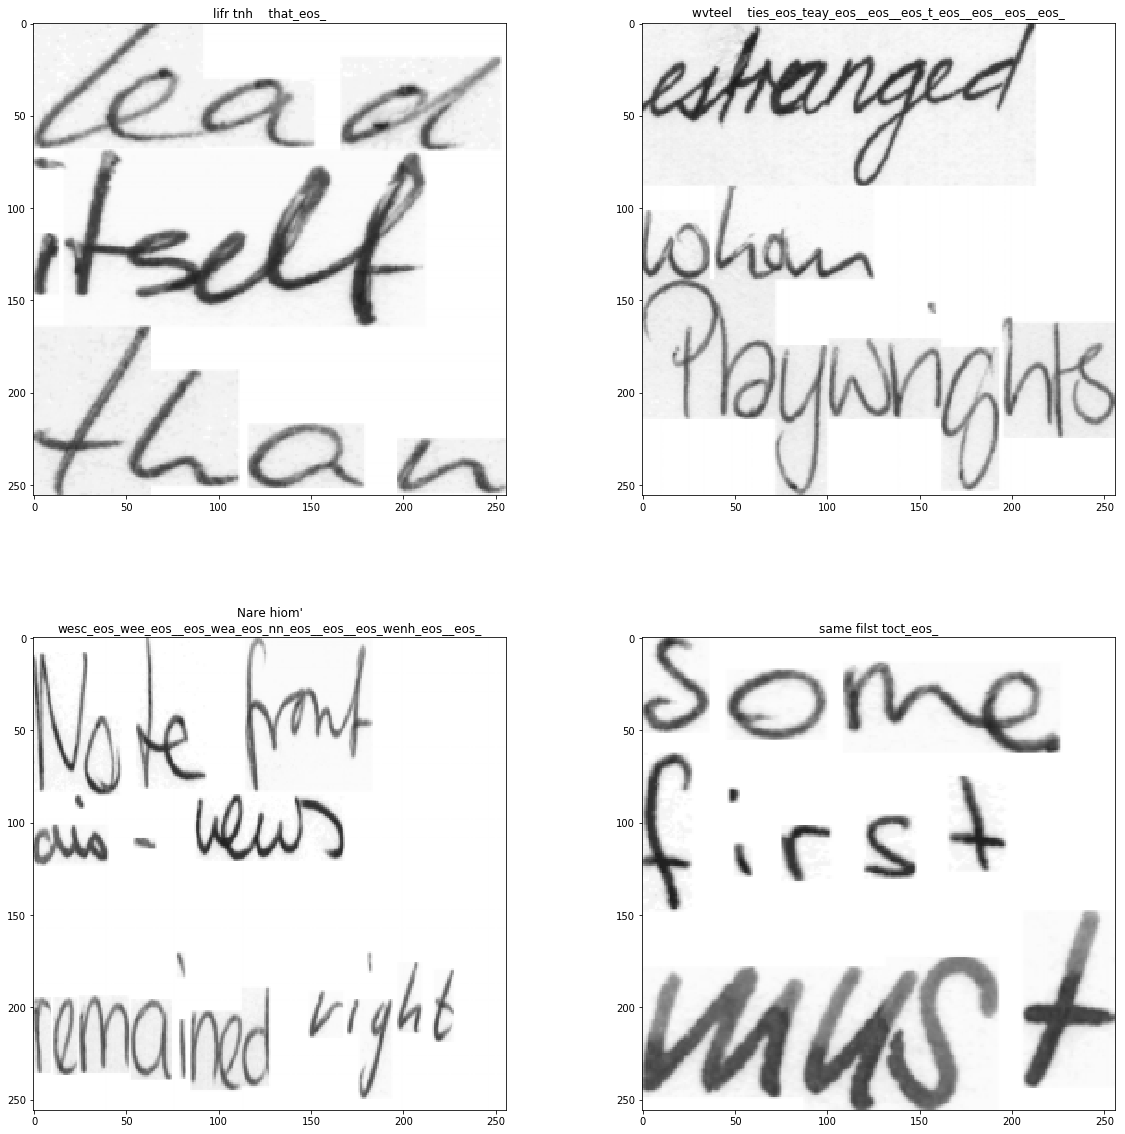

In [58]:
# res = torch.argmax(preds, dim=-1)
denorm = data.val_ds.denorm

fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = char_label_text(res[i])
    ax=show_img(denorm(x[i])[0], ax=ax, title=t)

### Previous Results

In [ ]:
# 3x1: XE/bs, kaiming_normal, no pos_enc, emb/out weight tying, no encoder, 2 layers, 256/256, single attn
# 52.199187  50.1736    0.730092    lr:1e-4
# 17.318725  13.803769  0.205331    2nd run, lr: 1e-3
# 11.96539   9.991971   0.151522    3rd run, lr: 1e-4     **tfmr

# Loss fns
# 43.177135  41.245482  1.185836    LabelSmoothing (KL/bs)
# 4215.8745  4012.3099  0.957795    LabelSmoothing (KL)
# 45.200728  43.662235  0.753881    LabelSmoothing (KL/bs w/out padding logic)  perplexity < BLEU/acc
# 5340.5770  5129.8346  0.738853    XE                    --- scaling by BS not a factor
# 52.199187  50.1736    0.730092    XE/bs  **

# Initialization/Activation
# 52.199187  50.1736    0.730092    kaiming_normal  (ff activation: leaky_relu)
# 52.987157  50.976083  0.758013    kaiming_uniform
# 49.553779  47.270616  0.702353    xavier_normal
# 49.380884  47.345175  0.673508    xavier_uniform  (ff activation: leaky_relu)   **
# 49.849071  47.369221  0.708807    xavier_uniform  (ff activation: relu)

# Positional Encoding
# 35.426869  30.449724  0.423573    target only; no embed/out weight tying   **
# 35.390268  31.216677  0.45097     "" ; w/ scaling factor [* math.sqrt(d_model)]
# 45.596748  42.213515  0.572662    target only; w/ embed/out weight tying

# Encoder
# 34.46771   29.207974  0.408425    **

# Attention
# 32.087941  26.431674  0.362717    SingleHead - linear layers for (q,k,v)
# 37.739475  32.962685  0.454753    MultiHead (8)
# 36.09057   31.346036  0.432342    MultiHead (4)
# 31.069687  26.00539   0.360032    MultiHead (1)     **

# N layers (6)
# 51.119606  48.809905  0.645302

# d_model = 512
# 21.032752  17.234559  0.230763    ~11:35  **

# em_sz
# 27.589121  22.698359  0.307399    128  ~14:09
# 28.320952  24.183105  0.338207    512  ~11:31

# include layer_norm in encoder/decoder
# 24.035412  19.824303  0.270881   modified: self.norm(x + self.dropout(sublayer(x)))
# 20.347157  17.23408   0.228328   original:  x + self.dropout(sublayer(self.norm(x)))   **tfmr_experiment
# 10.732795  9.875141   0.12633    2nd run



# 3x2 attention/pos_enc experiments
# 44.391676  40.633241  0.308526    baseline (src before self attn)    ~1h 7m
# 18.111974  18.16437   0.117756    10 cycles                          ~1h 52m      tmp_base
# 57.85619   51.015644  0.418202    pos_enc2d/no encoder; 256 + conv 1   ~44m       
# 27.356499  24.327117  0.17227     2nd run - attention not working well            tmp_2
# 16.581052  15.659028  0.104724    3rd run                                         tmp_3
# 55.944376  52.067722  0.417235    baseline w/ pos_enc2d; 256 + conv1    ~57m      tmp2


# 3x1, 1e-4, 10 cycles, N: 2
# 23.452119  20.750421  0.30148     conv, enc: pos2d, out: Linear    ~20m
# 10.747468  11.945359  0.148952    2nd run

# 22.816471  20.652263  0.300892    w/ STN (32/7/5/32/32) before img_encoder
# 24.154148  21.474449  0.314114    w/ STN (32/7/5/64/64) before img_encoder
# 24.315829  21.928237  0.319867    adding bn after conv (no STN)
# 25.852014  23.393568  0.345979    "", w/ STN(em_sz, d_model, 2) after img_encoder
# 22.586863  20.337497  0.294407    "", w/ STN (32/7/5/32/32) before img_encoder     ~21m
# 11.062696  11.752348  0.146163    2nd run

# 17.356167  15.935936  0.223704    linear, enc: None, out: Linear    ~19m
# 15.614188  14.634603  0.205307    conv/bn, enc: None, out: Linear    ~19m   **
# 17.618474  15.867109  0.220721    ""    ~20m
# 8.634967   9.732577   0.13152     2nd run    'tmp'  [src-attn tracks well]

# 17.213856  16.036616  0.228302    conv/bn, enc: None, out: MLP    ~20m
# 17.269863  16.052437  0.224499    conv/bn, enc: Encoder, out: Linear    ~23m
# 17.999301  16.085523  0.223856    conv/bn, enc: pos2d, out: Linear    ~19m
# 19.352792  17.537506  0.249201    conv/bn, STN(32/7/5), enc: pos2d, out: Linear ~21m
# 21.778735  19.844897  0.288944    conv/bn, STN(32/7/5), enc: pos2d, out: MLP    ~22m

# 15.627235  14.005776  0.18804     dec: w/ self-attn + src-attn
# 7.056934   7.818964   0.10034     2nd run    'tmp2'    [loss decrease but src-attn tracks worse]

# 17.841002  16.682544  0.221875    enc: src-attn, dec: self-attn, mixer: +tanh   ~22m
# 6.         8.         0.12        2nd run

# 15.780708  14.452696  0.205315    enc: src-attn, dec: self-attn, mixer: cat/lin   ~20m    'tmp3'

# N: 4
# 14.322309  13.357375  0.190247    enc: src-attn, dec: self-attn, mixer: cat/lin   ~25m
# 7.48091    7.132944   0.092341    "", dec: preloaded LM

# paragraph, 1e-4, 10 cycles, N: 4
# 691.015346 621.679181 0.645048    enc: src-attn, dec: preloaded LM, mixer: cat/lin

# Test

In [41]:
from scipy.ndimage import gaussian_filter
k=16

def torch_scale_attns(attns):
    bs,sl,hw = attns.shape
    num = int(math.sqrt(hw))   # sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = F.interpolate(mod, size=sz)
    return scaled  #([bs, sl, h, w])

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [42]:
def self_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].self_attn.attn.data
def source_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].src_attn.attn.data

In [90]:
learn.load('tfmr_full_3x1')

In [44]:
v_dl = iter(data.val_dl)
denorm = data.val_ds.denorm

## Results

In [45]:
x,y = next(v_dl)
imgs = denorm(x)

shifted_y = rshift(y).long()
tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)

learn.model.eval()

v_preds = learn.model(x, shifted_y, tgt_mask)
v_res = torch.argmax(v_preds, dim=-1)
v_attn = source_attn()

g_preds = learn.model.greedy_decode(x, seq_len)
g_res = torch.argmax(g_preds, dim=-1)
g_attn = source_attn()

 84%|████████▍ | 211/250 [00:11<00:02, 17.76it/s]

In [83]:
v = [learn.crit(v_preds, y).item(), cer(v_preds, y), acc(v_preds, y).item()]
print(f'valid:     {str(v[0])[:7]}   {str(v[1])[:7]}   {str(v[2])[:7]}')

g = [learn.crit(g_preds, y).item(), cer(g_preds, y), acc(g_preds, y).item()]
print(f'greedy:    {str(g[0])[:7]}   {str(g[1])[:7]}   {str(g[2])[:7]}')

valid:     6.55702   0.08746   0.93483
greedy:    42.5729   0.10094   0.75906


In [ ]:
# tfmr full
#             loss       cer       acc
# valid:     2.42856   0.02981   0.98177   3x1, 256/60, 'tfmr_full_3x1_single_attn'
# greedy:    11.9438   0.02745   0.93385

# valid:     1.47604   0.00797   0.99523   3x2, 400/45,  'tfmr_full_3x2'
# greedy:    21.4682   0.01097   0.93762

# valid:     7.30494   0.01206   0.99086   lg,  512,30,  'tfmr_full_lg'
# greedy:    866.544   0.14109   0.37214

## 3x1 256

### Images

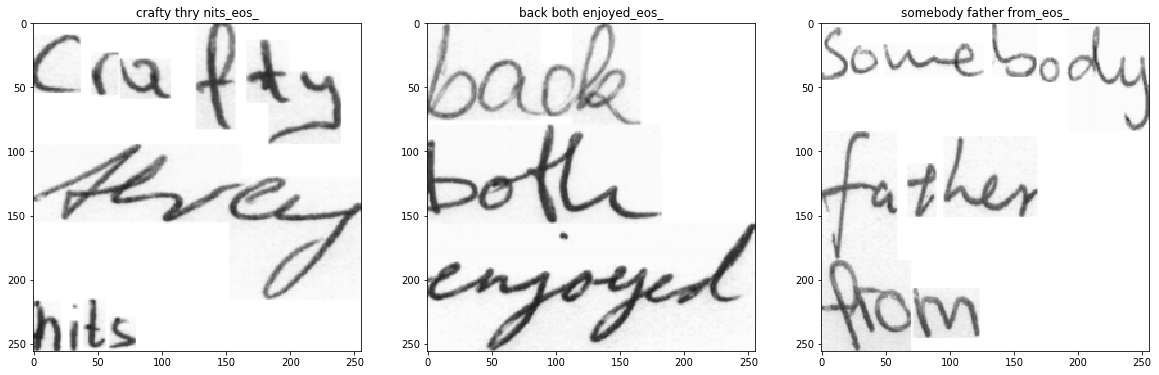

In [69]:
#valid
fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.4}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(v_res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

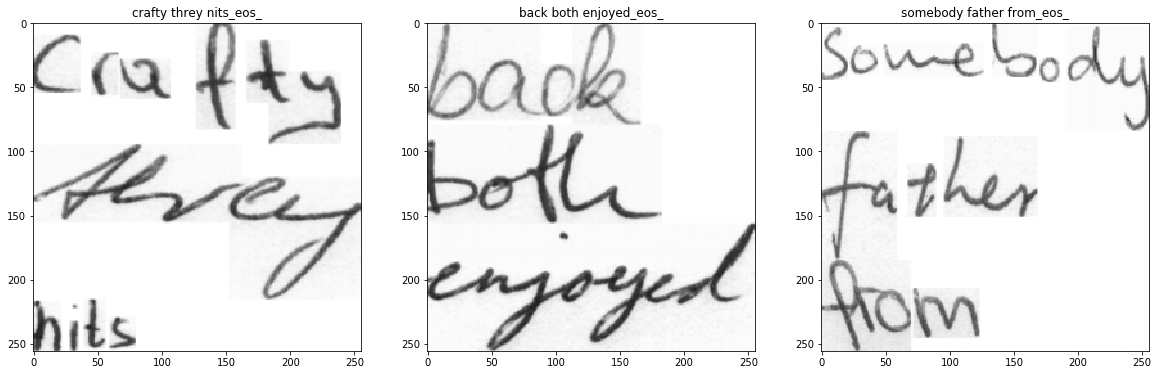

In [70]:
#greedy
fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.4}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(g_res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

### Source Attn

In [71]:
idx = 1
img = imgs[idx]

v_chars = v_res[idx]
v_attns = to_np(torch_scale_attns(v_attn)[idx])

g_chars = g_res[idx]
g_attns = to_np(torch_scale_attns(g_attn)[idx])

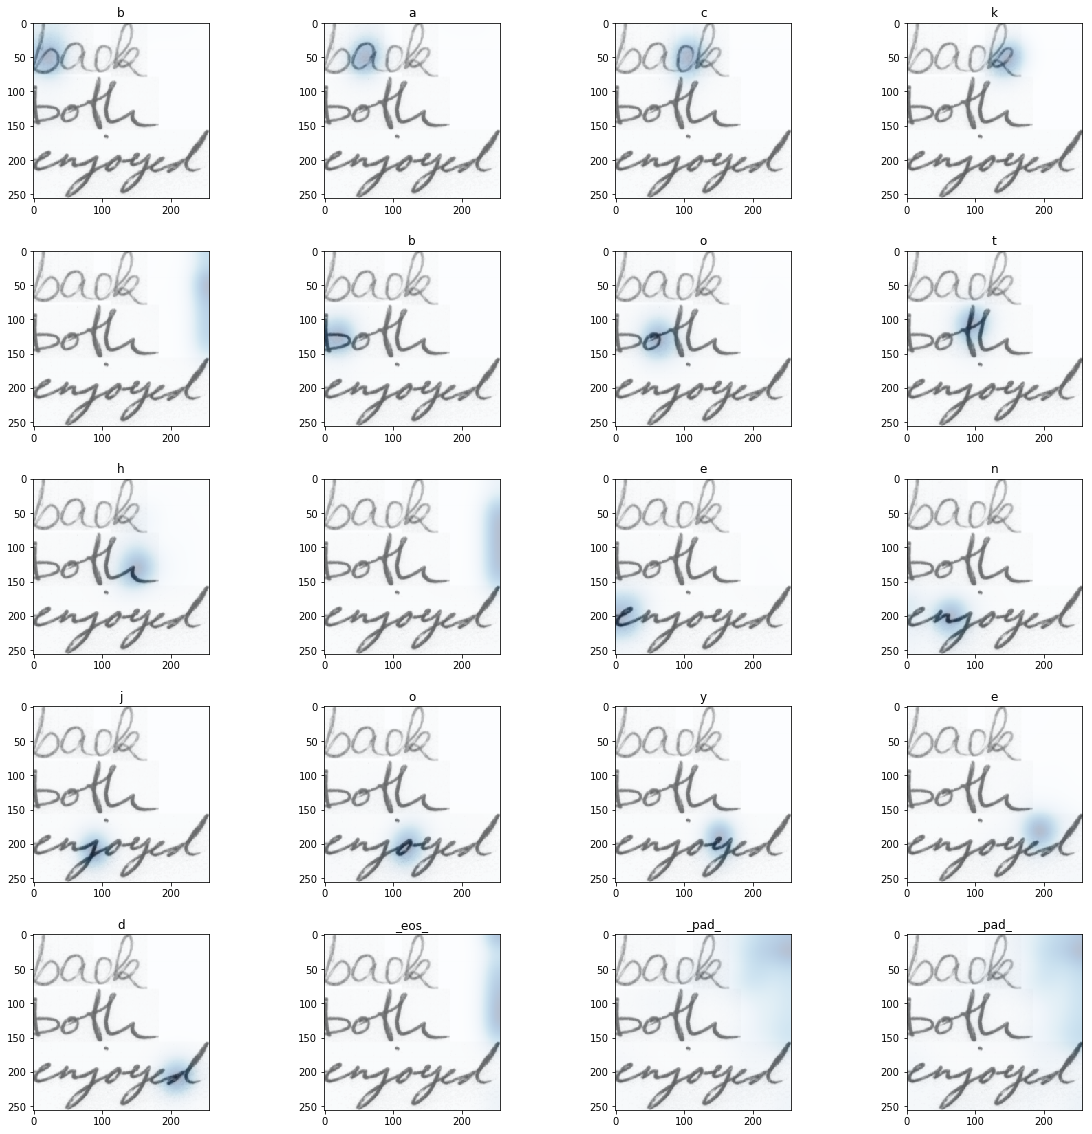

In [76]:
#valid
fig, axes = plt.subplots(5,4, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(v_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[v_chars[i].item()])

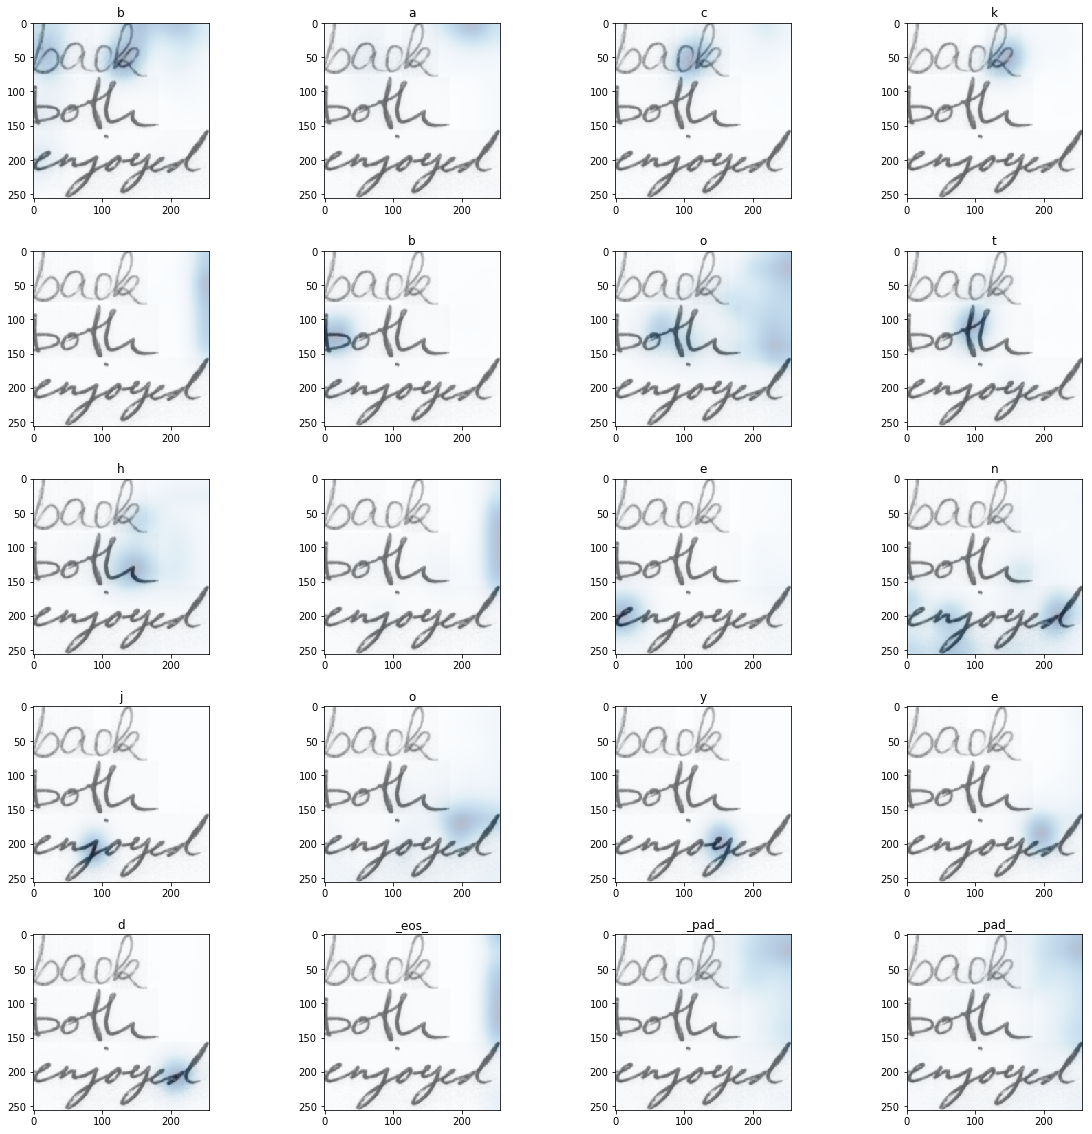

In [77]:
#greedy
fig, axes = plt.subplots(5,4, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(g_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[g_chars[i].item()])

## 3x2 400

### Images

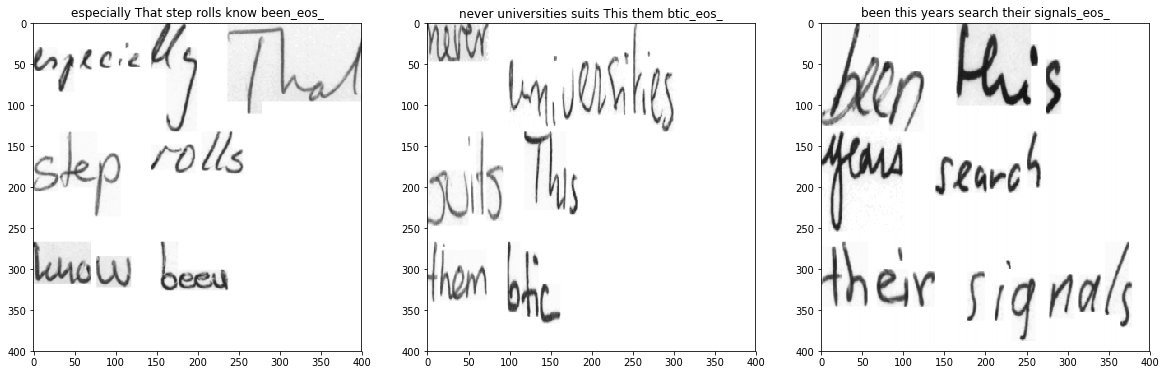

In [88]:
#valid
fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.4}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(v_res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

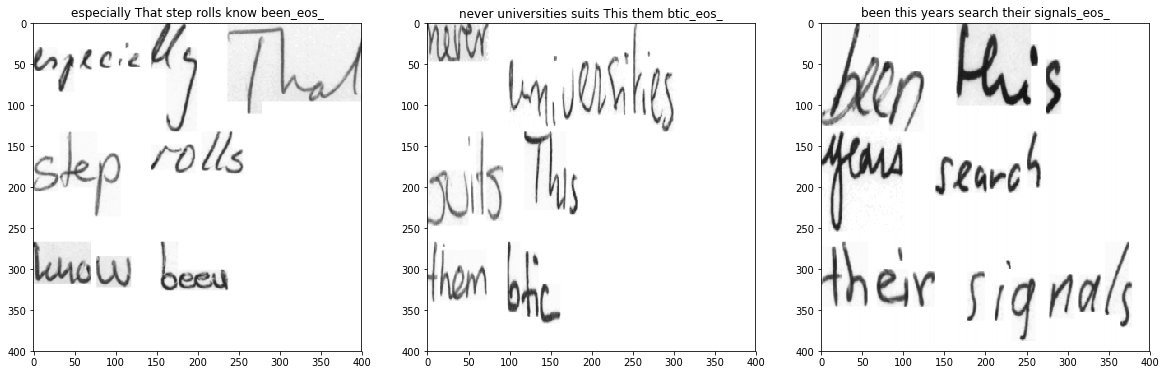

In [89]:
#greedy
fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.4}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(g_res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

### Source Attn

In [90]:
idx = 1
img = imgs[idx]

v_chars = v_res[idx]
v_attns = to_np(torch_scale_attns(v_attn)[idx])

g_chars = g_res[idx]
g_attns = to_np(torch_scale_attns(g_attn)[idx])

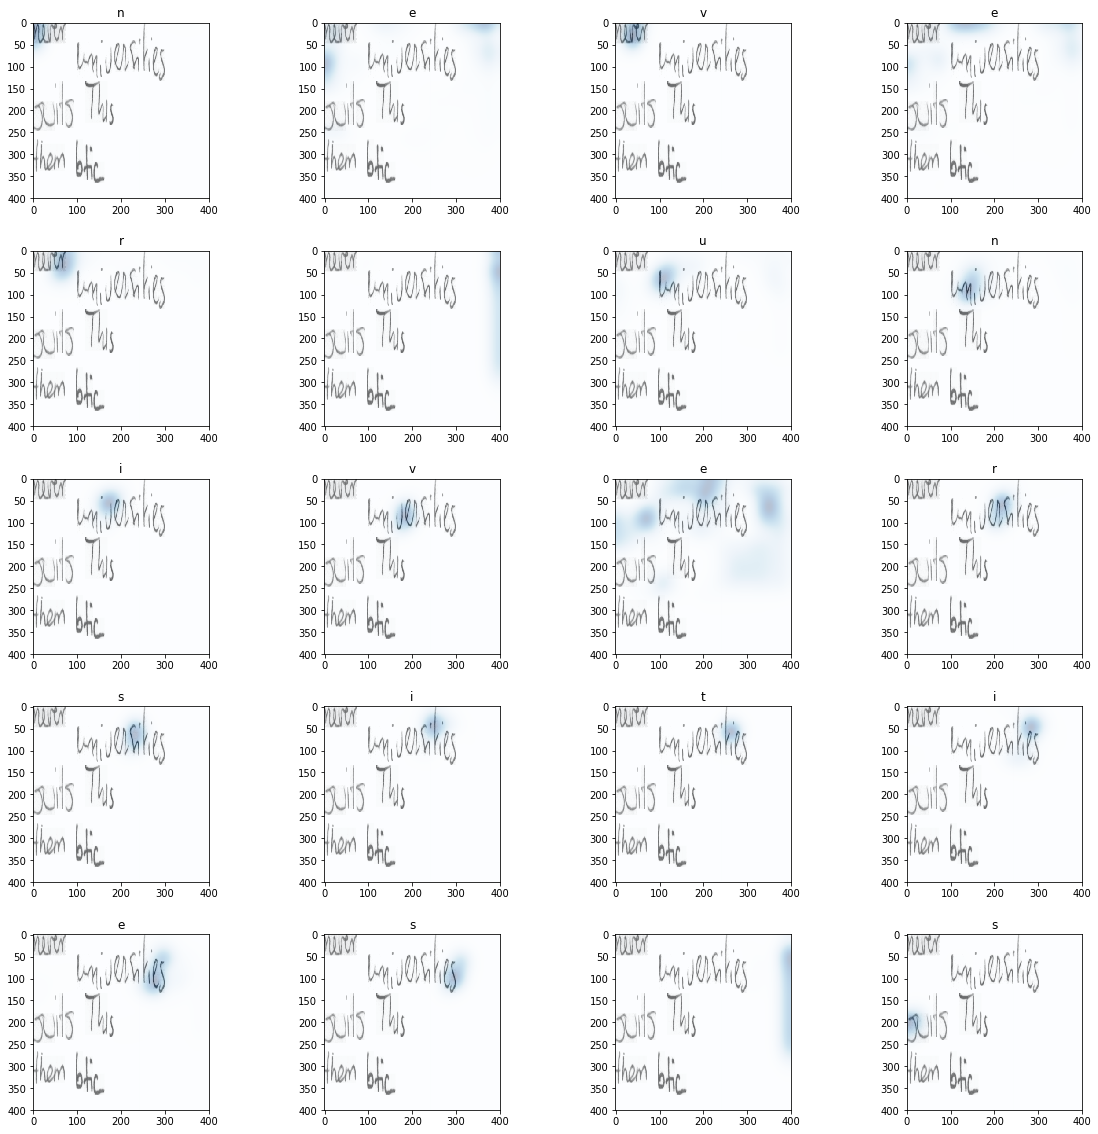

In [91]:
#valid
fig, axes = plt.subplots(5,4, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(v_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[v_chars[i].item()])

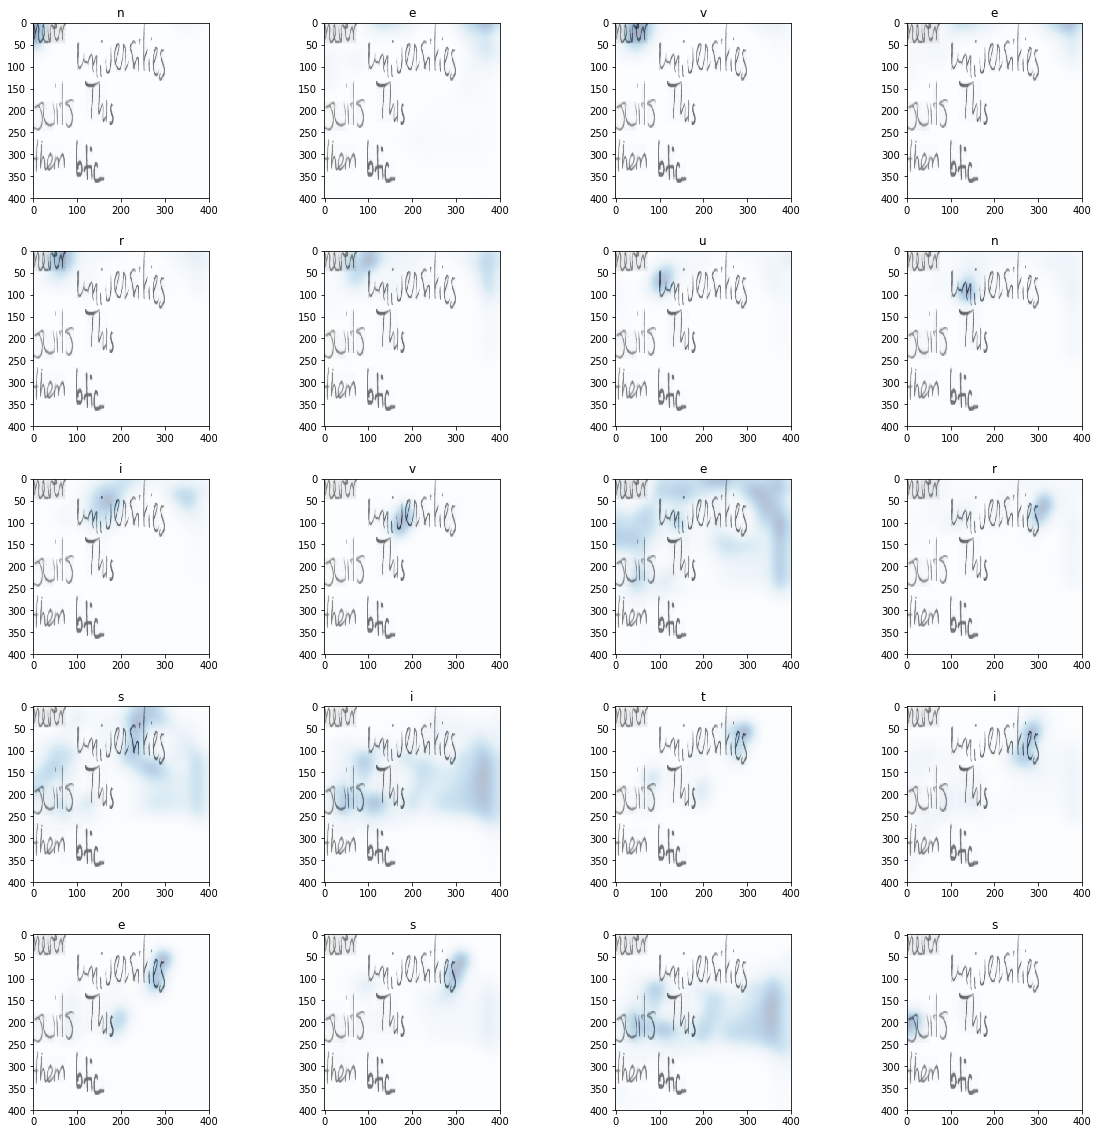

In [92]:
#greedy
fig, axes = plt.subplots(5,4, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(g_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[g_chars[i].item()])

## lg 512

### Images

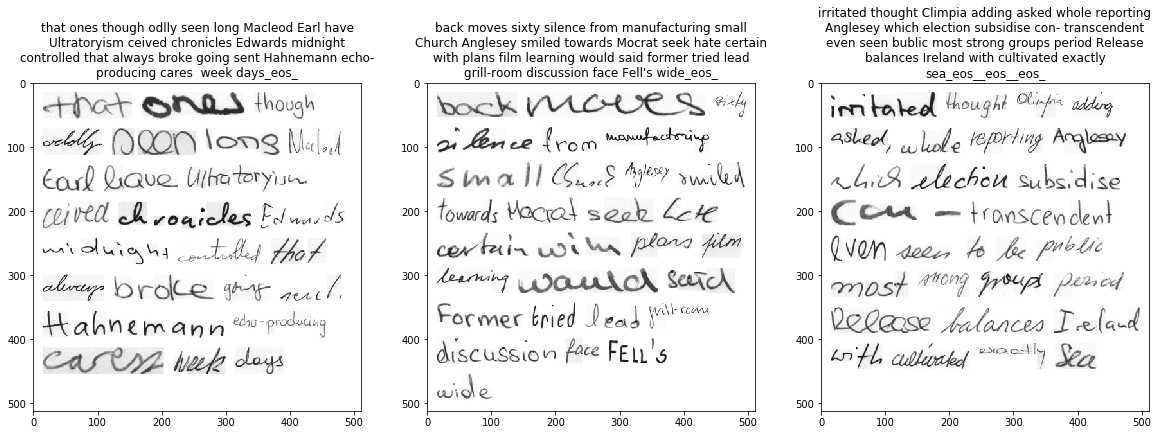

In [49]:
#valid
fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.4}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(v_res[i], chunk=55)
    ax=show_img(imgs[i], ax=ax, title=p)

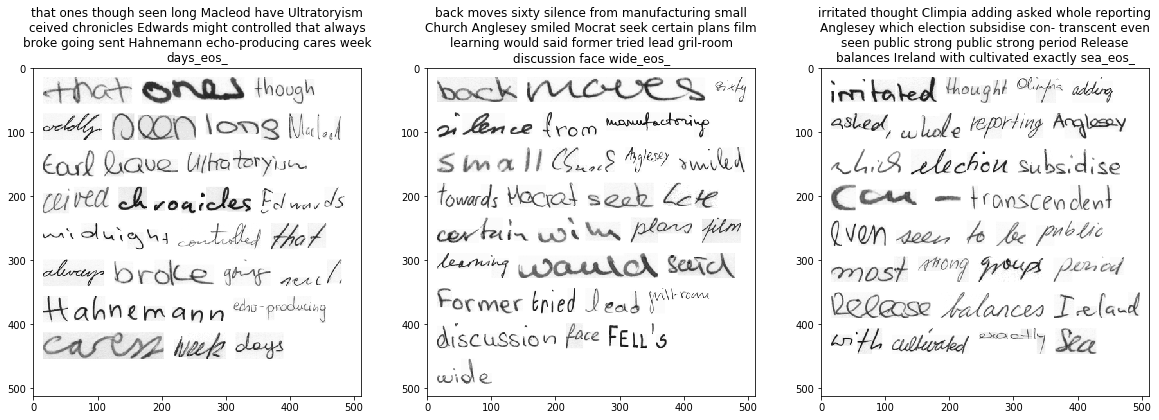

In [50]:
#greedy
fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.4}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(g_res[i], chunk=55)
    ax=show_img(imgs[i], ax=ax, title=p)

### Source Attn

In [51]:
idx = 1
img = imgs[idx]

v_chars = v_res[idx]
v_attns = to_np(torch_scale_attns(v_attn)[idx])

g_chars = g_res[idx]
g_attns = to_np(torch_scale_attns(g_attn)[idx])

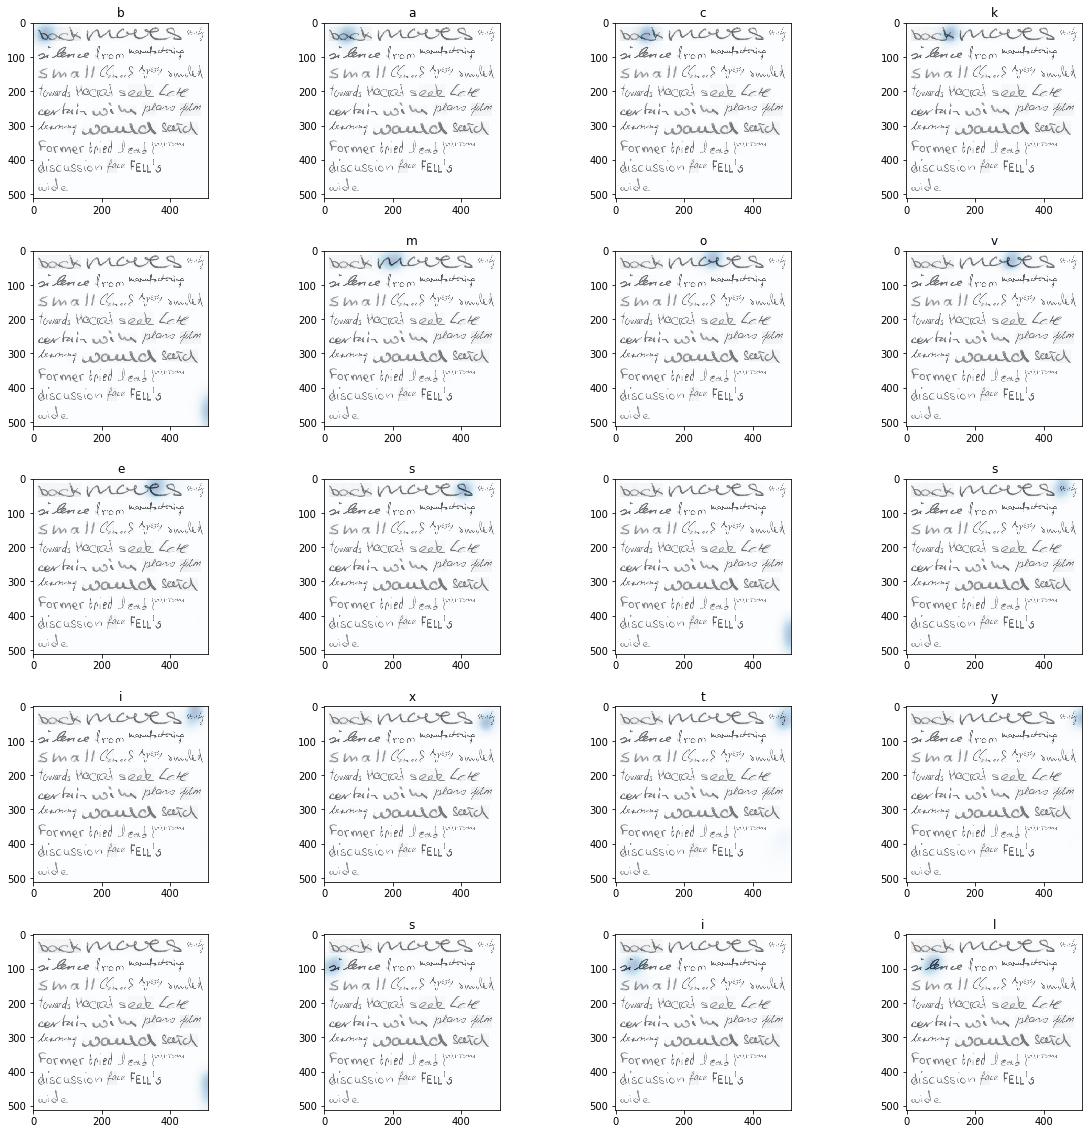

In [52]:
#valid
fig, axes = plt.subplots(5,4, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(v_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[v_chars[i].item()])

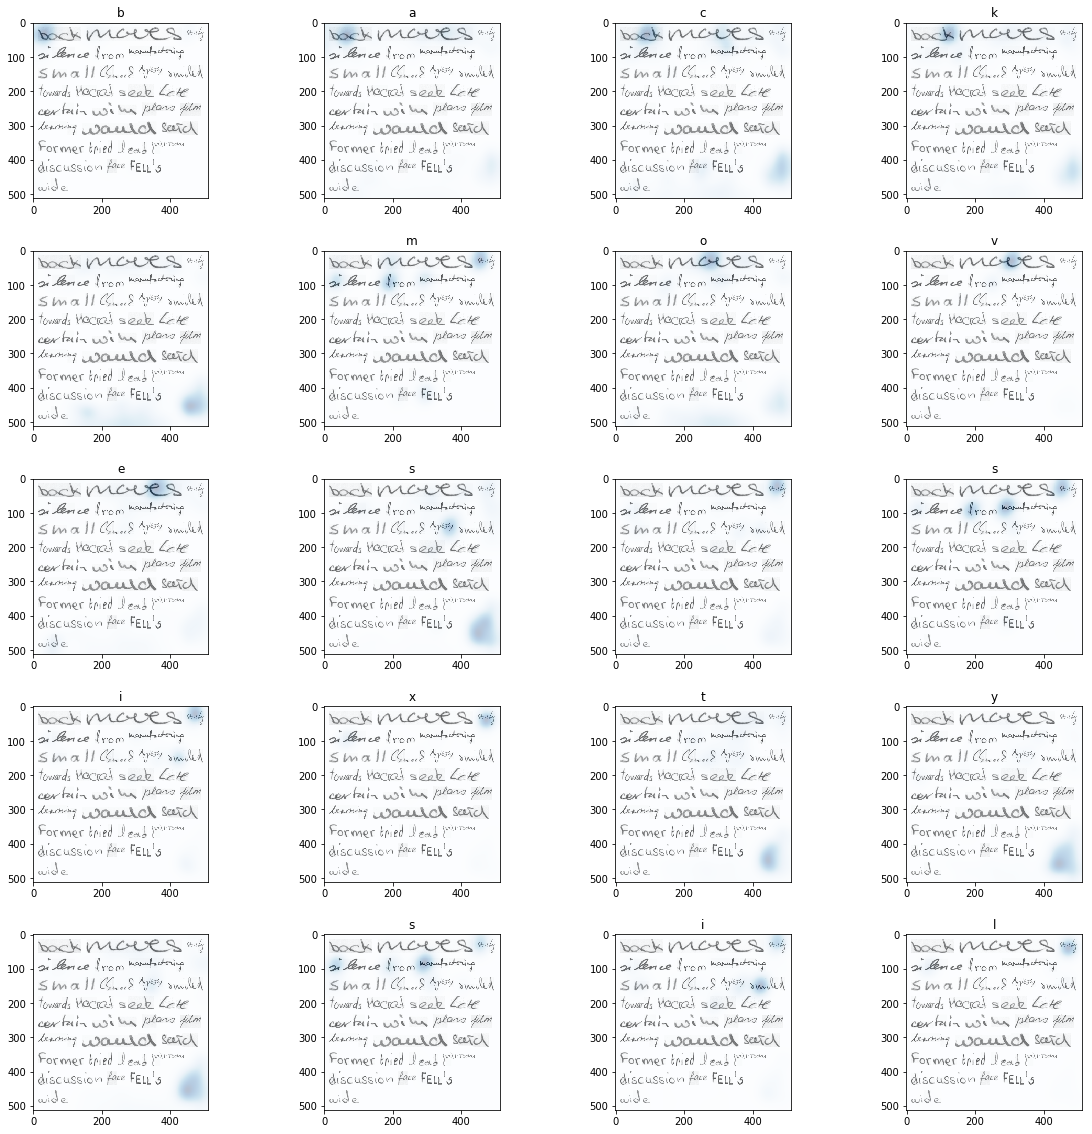

In [53]:
#greedy
fig, axes = plt.subplots(5,4, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(g_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[g_chars[i].item()])

## Greedy Decode

In [51]:
x,y = next(v_dl)
imgs = denorm(x)

learn.model.eval()
preds = learn.model.greedy_decode(x, seq_len)
res = torch.argmax(preds, dim=-1)

 64%|██████▍   | 29/45 [00:00<00:00, 53.49it/s]


In [52]:
p = [learn.crit(preds, y).item(), cer(preds, y), acc(preds, y).item()]
print(f'greedy:    {round(p[0],5)}   {round(p[1],6)}   {round(p[2],6)}')

greedy:    13.38979   0.037453   0.91875


In [55]:
# tfmr full
# greedy:    13.38979   0.037453   0.91875   3x1, 256, 'tfmr_full_3x1_single_attn'


# tfmr
#  loss        cer    perplexity    input
# 256
# 9.9722     0.1029    3.5850      baseline, 3x2
# 15.9952    0.1174    8.2054      256+conv, pos_enc2d, 3x2

# 800
# 578.0068   0.0560    9.5205      cat678

# sz: 1000
# 2072.9954  0.3545    63.7585     catpg
# 2491.7947  0.3417    386.123     pg

tensor(105.2643, device='cuda:0')

### Images

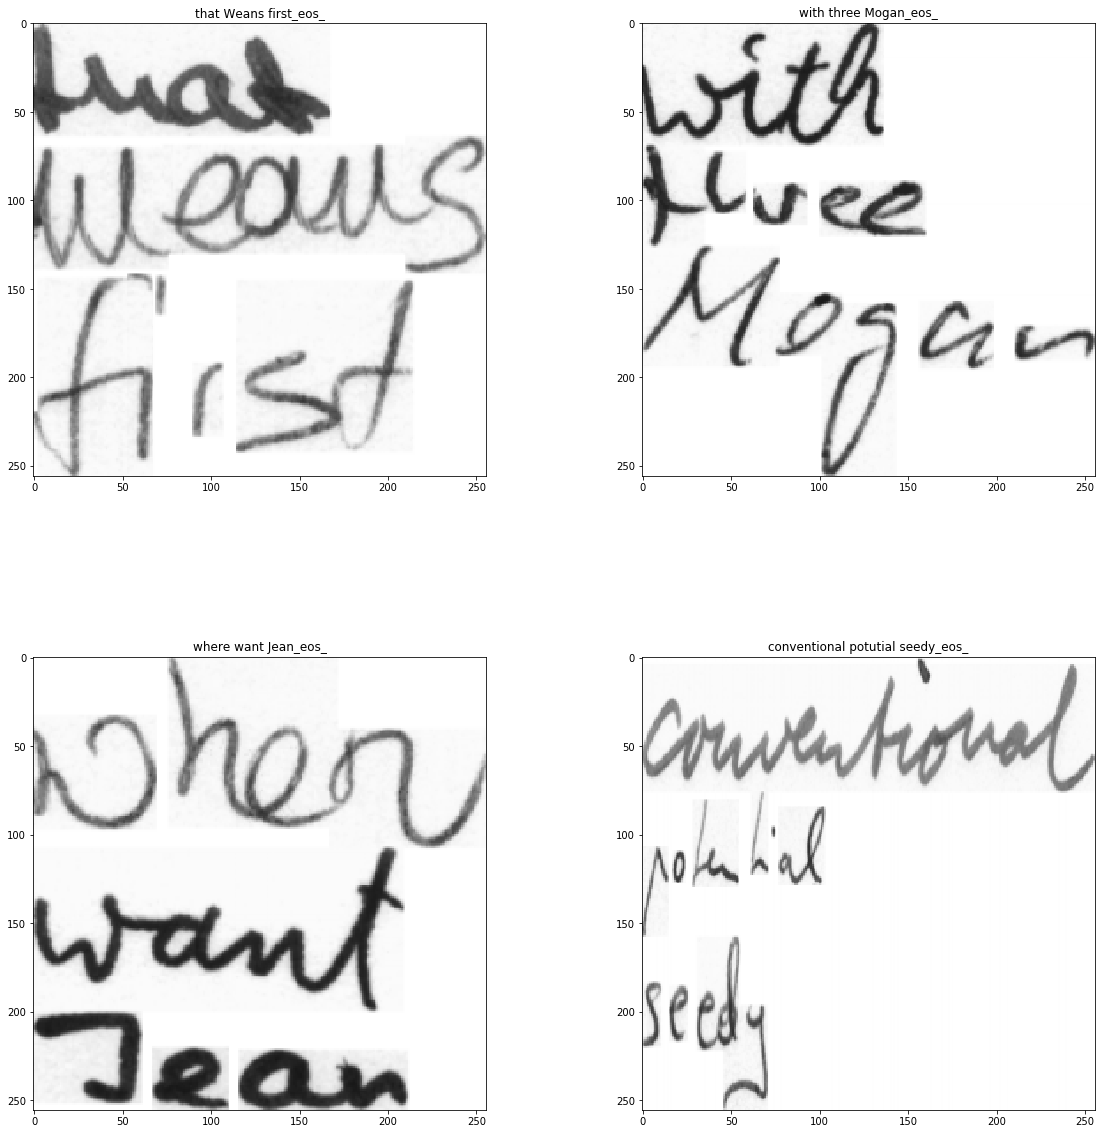

In [53]:
fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.4}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    p = char_label_text(res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

### Src Attention

#### 4 heads

In [74]:
# 4 heads
src_attn = source_attn()[0]  #([4, 21, 256])   # 4 attn heads
# pred = g_res[0]
img_attns = to_np(torch_scale_attns(src_attn)) # heads, sl, h, w

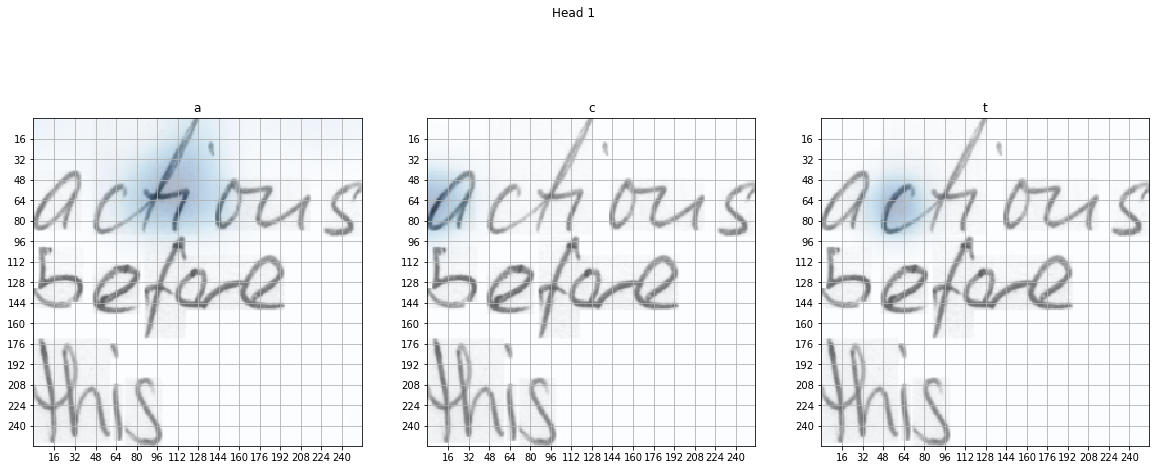

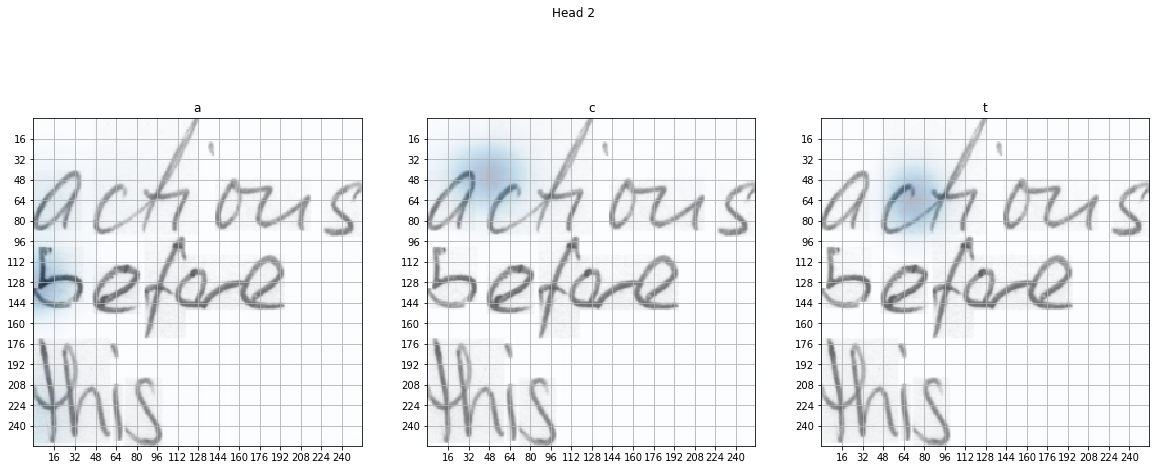

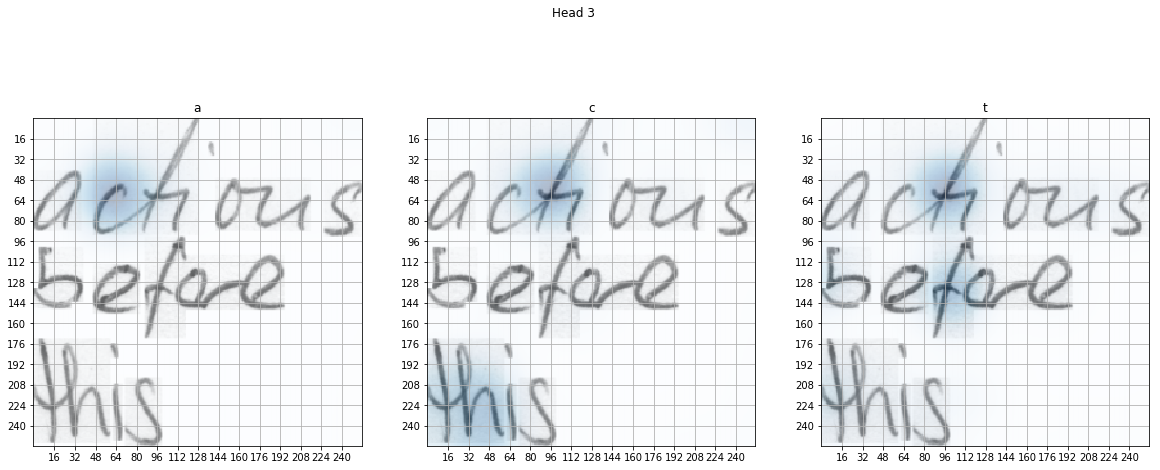

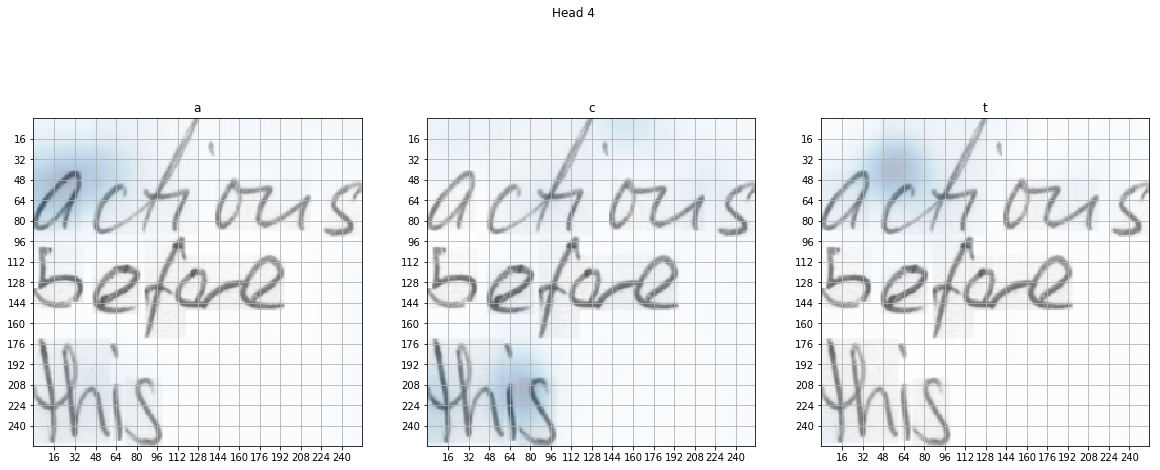

In [80]:
#attn heads (first layer)
src_attn = source_attn(0)[0]
img_attns = to_np(torch_scale_attns(src_attn)) # heads, sl, h, w

for h in range(4):
    fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 8))
    fig.suptitle(f"Head {h+1}")
    for i,ax in enumerate(axes.flat):
        a = g_filter(img_attns[h,i])
        ax.imshow(img, alpha=None)
        ax.imshow(a, cmap='Blues', alpha=0.3)

        # Attention
        ticks = np.arange(k, sz, k)
        ax.set_yticks(ticks, minor=False)
        ax.set_xticks(ticks, minor=False)
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)

        ax.set_title(itos[pred[i].item()])

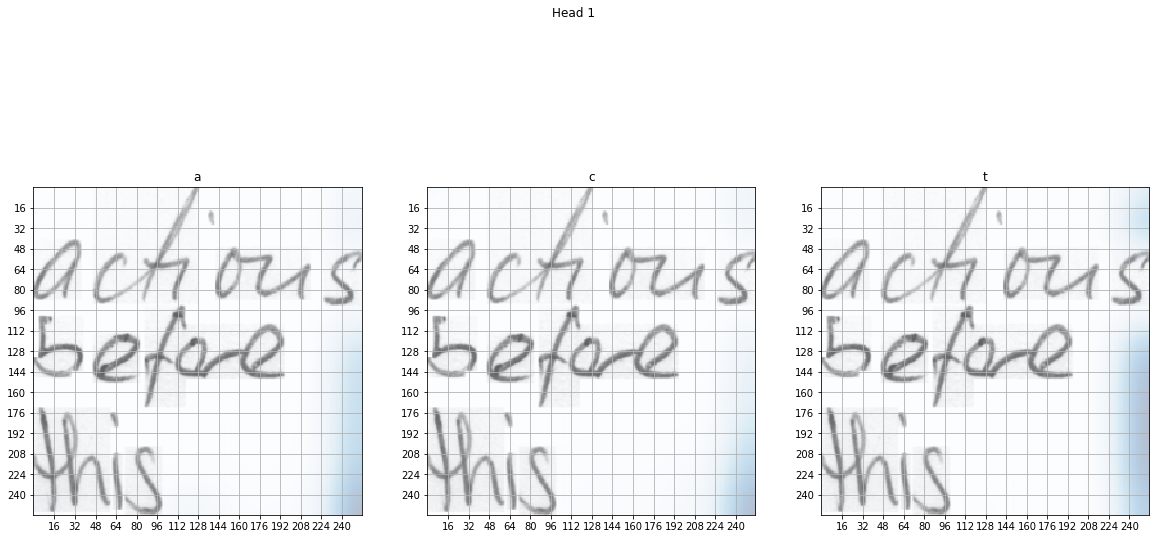

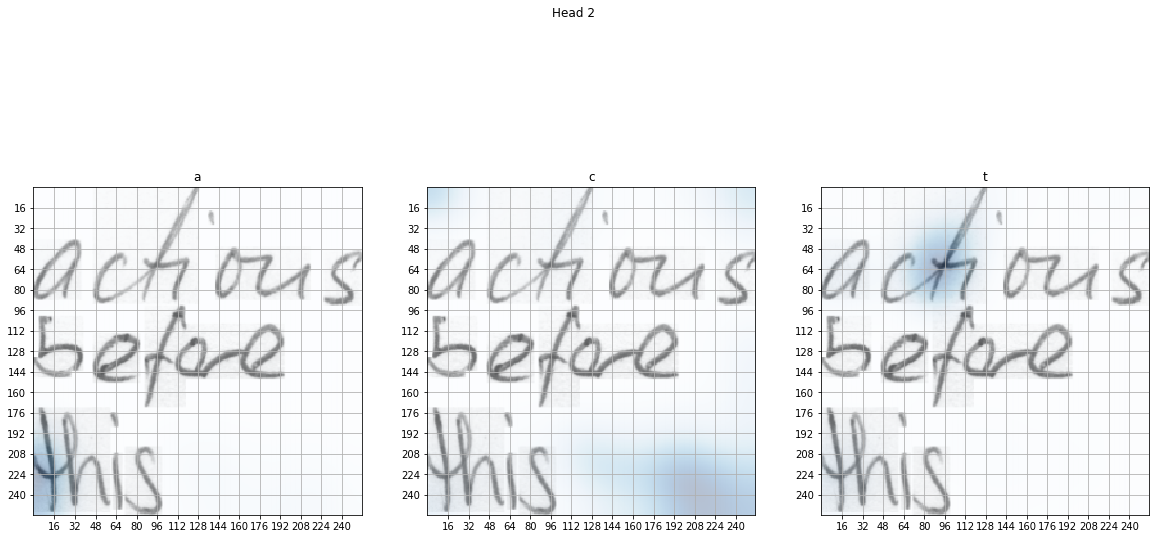

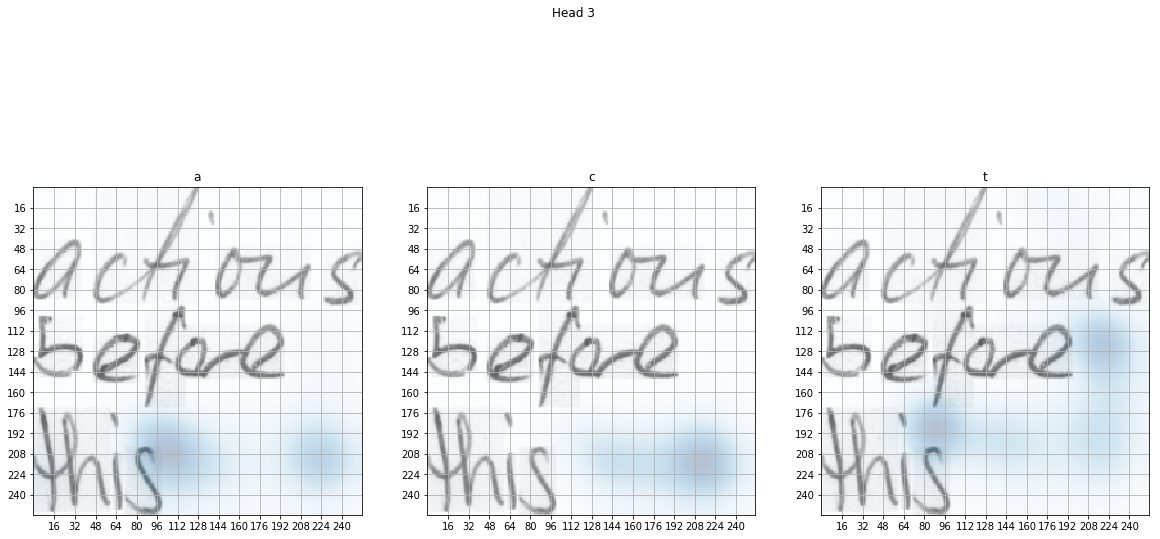

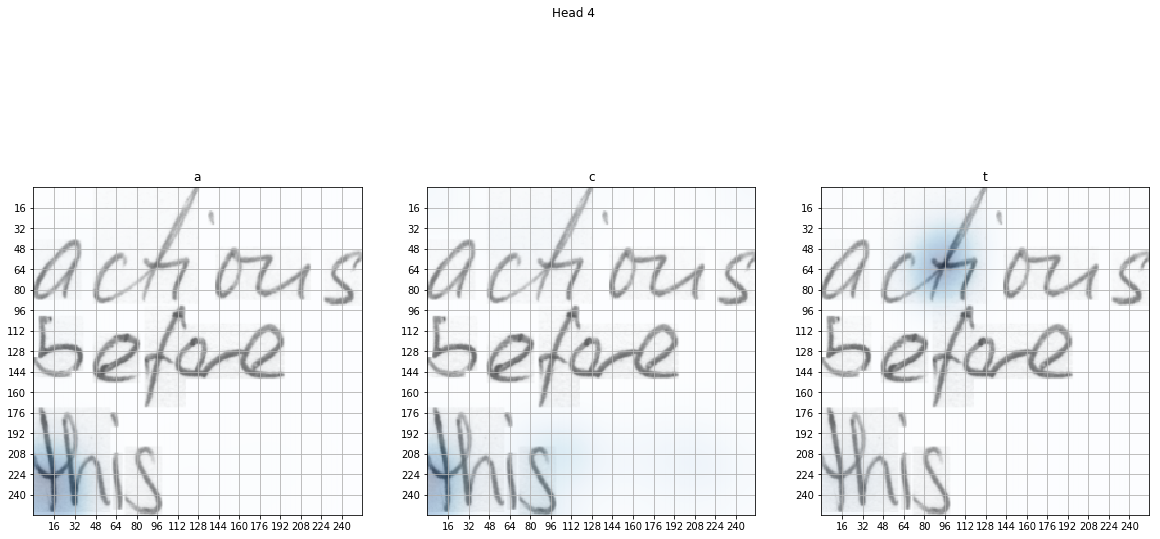

In [79]:
#attn heads (last_layer)
for h in range(4):
    fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 10))
    fig.suptitle(f"Head {h+1}")
    for i,ax in enumerate(axes.flat):
        a = g_filter(img_attns[h,i])
        ax.imshow(img, alpha=None)
        ax.imshow(a, cmap='Blues', alpha=0.3)

        # Attention
        ticks = np.arange(k, sz, k)
        ax.set_yticks(ticks, minor=False)
        ax.set_xticks(ticks, minor=False)
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)

        ax.set_title(itos[pred[i].item()])

#### single head

### Target (self) Attn

Decoder Self Layer 1


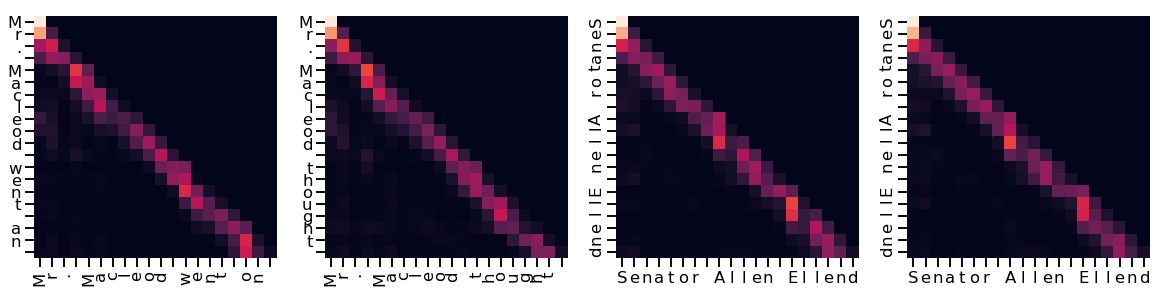

Decoder Self Layer 2


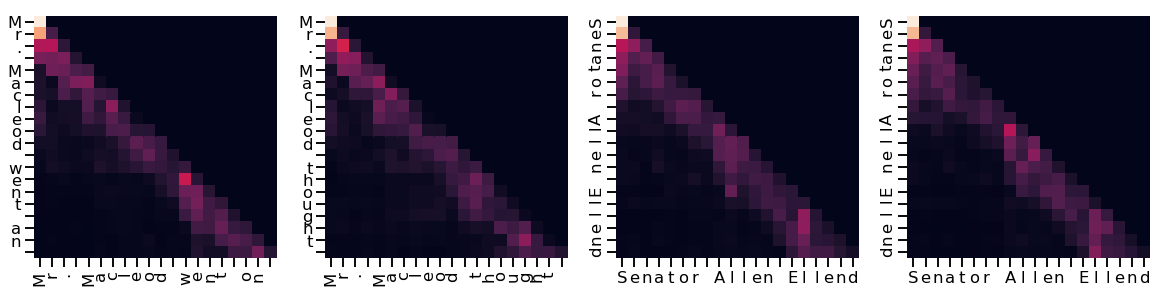

In [70]:
sns.set_context(context="talk")

def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, cbar=False, ax=ax)

# h = 0  #attn head
for layer in range(2):
    print("Decoder Self Layer", layer+1)
    fig, axes = plt.subplots(1,4, figsize=(20, 10))
    for i,ax in enumerate(axes.flat):  # multi example
        pred = char_split_text(res[i])[:20]   # only last 20
        true = char_split_text(y[i])[:20]     # only last 20
        draw(self_attn(layer)[i].data[:len(true), :len(true)], true, pred, ax=ax)
    plt.show()

In [80]:
idx = 0
img = imgs[idx]
pred = res[idx]
# img_attns = source_attn()[idx]
img_attns = torch_scale_attns(source_attn())[idx]

In [ ]:
fig, axes = plt.subplots(8,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 50))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    
#     ax.imshow(a, cmap='magma', alpha=0.3, shape=(sz,sz), interpolation='bilinear')
    ax.imshow(a, cmap='Blues', alpha=0.3)

    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

## Beam Search

In [56]:
# https://geekyisawesome.blogspot.com/2016/10/using-beam-search-to-generate-most.html

import heapq

class Beam(object):
    '''
    For comparison of prefixes, the tuple (prefix_probability, complete_sentence) is used.
    This is so that if two prefixes have equal probabilities then a complete sentence
    is preferred over an incomplete one since (0.5, False) < (0.5, True)
    '''

    def __init__(self, beam_width):
        self.heap = list()
        self.beam_width = beam_width

    def add(self, prob, complete, prefix):
        heapq.heappush(self.heap, (prob, complete, prefix))
        if len(self.heap) > self.beam_width:
            heapq.heappop(self.heap)
    
    def __iter__(self):
        return iter(self.heap)

In [57]:
def beamsearch(probabilities_function, beam_width=10, clip_len=-1, start_tok=1, end_tok=0):
    prev_beam = Beam(beam_width)
    prev_beam.add(1.0, False, [ start_tok ])
    while True:
        curr_beam = Beam(beam_width)
        
        #Add complete sentences that do not yet have the best probability to the current beam,
        #the rest prepare to add more words to them.
        for (prefix_prob, complete, prefix) in prev_beam:
            if complete == True:
                curr_beam.add(prefix_prob, True, prefix)
            else:
                #Get probability of each possible next word for the incomplete prefix.
                for (next_prob, next_word) in probabilities_function(prefix):
                    if next_word == end_tok:
                        #if next word is the end token then mark prefix as complete and leave out the end token
                        curr_beam.add(prefix_prob*next_prob, True, prefix)
                    else: 
                        #if next word is a non-end token then mark prefix as incomplete
                        curr_beam.add(prefix_prob*next_prob, False, prefix+[next_word])
        
        (best_prob, best_complete, best_prefix) = max(curr_beam)
        if best_complete == True or len(best_prefix)-1 == clip_len:
            #if most probable prefix is a complete sentence or has a length that exceeds 
            #the clip length (ignoring the start token) then return it
            return (best_prefix[1:], best_prob)
            #return best sentence without the start token and together with its probability
            
        prev_beam = curr_beam

In [61]:
def beam_decode(net, src, beam_width, seq_len):
    with torch.no_grad():
        feats = net.transformer.encode(net.img_enc(src))        
        gold, score = beamsearch(partial(prob_func, net=net, feats=feats, beam_width=beam_width), beam_width, seq_len)
        return gold
    
def prob_func(tgt, net=None, feats=None, beam_width=10):
    tgt = torch.tensor([tgt], dtype=torch.long, device=device)
    dec_outs = net.transformer.decode(feats, Variable(tgt))
    logits = net.transformer.generate(dec_outs[:,-1])
    res = torch.topk(F.softmax(logits, -1), beam_width, dim=-1)
    return zip(res[0][0].detach(),res[1][0].detach())

In [62]:
b_res = beam_decode(learn.model, x[0][None], 5, seq_len)
# pg, seq_len: 700, bs: 1, gpu  ~25.5s

In [ ]:
st = ''.join([itos[i] for i in b_res])
p = '\n'.join(textwrap.wrap(st, 70))
show_img(denorm(x[0][None])[0], figsize=(10,10), title=p)

In [55]:
# greedy
test_accuracy(res[0][None], y[0][None])

tensor(0.2510, device='cuda:0')

In [66]:
# beam
r = torch.tensor([b_res], dtype=torch.long, device=device)
test_accuracy(r, y[0][None])

tensor(0.2530, device='cuda:0')